### EXP

In [172]:
# !pip list
# if __name__ == '__main__':
!pwd
# !rm -r feature_map
# !ls
# !tree

/home/ubuntu/workspace/nni_sy/examples/trials/cifar100_part4_0513_0520_compare_gain_insight/cifar10_1_layer_wise_3_3_3_3_2conv_head


In [173]:
# coding: utf-8
import os
import torch
import torchvision.utils as vutils
import numpy as np
from tensorboardX import SummaryWriter
import torch.nn.functional as F
import torchvision.transforms as transforms
import sys
sys.path.append("..")
from torch.utils.data import DataLoader
import torchvision
from models import *
# from utils.utils import MyDataset, Net, normalize_invert
from torch.utils.data import Sampler
import matplotlib.pyplot as plt
from PIL import Image
import glob
# sys.path

In [174]:
class SubsetSampler(Sampler):
    r"""Samples elements from a given list of indices, without replacement.
    Arguments:
        indices (sequence): a sequence of indices
    """
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (i for i in self.indices)

    def __len__(self):
        return len(self.indices)

In [175]:
def random_choice(path_num, m, layers):
    # choice = {}
    import random
    import collections
    import numpy as np
    choice = collections.OrderedDict()
    # choice = {
    #     0: {'conv_0': [0], 'conv_1': [1, 2], 'conv_2': [0,2], 'rate': 0},
    #     2: {'conv_0': [0], 'conv_1': [0, 1], 'conv_2': [1,2], 'rate': 0}}

    # for i in range(len(layers)):
    for i in layers:
        # expansion rate 固定为1
        rate = np.random.randint(low=0, high=1, size=1)[0]
        # conv
        m_ = np.random.randint(low=1, high=(m+1), size=1)[0]
        rand_conv = random.sample(range(path_num), m_)

        m_2 = np.random.randint(low=1, high=(m + 1), size=1)[0]
        rand_conv_2 = random.sample(range(path_num), m_2)

        choice[i] = {'conv_0': [0], 'conv_1': rand_conv, 'conv_2': rand_conv_2,'rate': rate}
    return choice

In [176]:
# 查看 训练保存文件
# pretrained_path_list = glob.glob(os.path.join('./checkpoint/*.pkl'))
# pretrained_path_list = sorted(pretrained_path_list)
# for i in pretrained_path_list:
#     print(i)
# /home/ubuntu/workspace/nni_sy/examples/trials/cifar100_part4_0513_0520_compare_gain_insight/cifar10_1_layer_wise_3_3_3_3_2conv_head/checkpoint
# epoch_index = str(0).zfill(2)
# pretrained_path_list = glob.glob(os.path.join('./checkpoint/exp1_{}_net_params_*.pkl'.format(epoch_index)))
pretrained_path_list = glob.glob(os.path.join('./checkpoint/exp2_*.pkl'))
pretrained_path_list = sorted(pretrained_path_list)
for i in pretrained_path_list:
    print(i)
# pretrained_path = pretrained_path_list[0]
# print(pretrained_path.split('_'))
# current_lr = {str(5): pretrained_path_list[0].split('_')[-1][:-4]} # loc8
# print(current_lr)
# current_lr = {str(5): pretrained_path_list[0].split('_')[-3]} # loc0
# print(current_lr)

./checkpoint/exp2_00_net_params_loc0_1.78e-04_loc8_9.38e-04.pkl
./checkpoint/exp2_01_net_params_loc0_1.72e-04_loc8_9.10e-04.pkl
./checkpoint/exp2_02_net_params_loc0_1.65e-04_loc8_8.71e-04.pkl
./checkpoint/exp2_03_net_params_loc0_1.56e-04_loc8_8.22e-04.pkl
./checkpoint/exp2_04_net_params_loc0_1.45e-04_loc8_7.65e-04.pkl
./checkpoint/exp2_05_net_params_loc0_1.33e-04_loc8_7.01e-04.pkl
./checkpoint/exp2_06_net_params_loc0_1.20e-04_loc8_6.32e-04.pkl
./checkpoint/exp2_07_net_params_loc0_1.06e-04_loc8_5.60e-04.pkl
./checkpoint/exp2_08_net_params_loc0_9.20e-05_loc8_4.85e-04.pkl
./checkpoint/exp2_09_net_params_loc0_7.78e-05_loc8_4.11e-04.pkl
./checkpoint/exp2_10_net_params_loc0_6.41e-05_loc8_3.38e-04.pkl
./checkpoint/exp2_11_net_params_loc0_5.09e-05_loc8_2.69e-04.pkl
./checkpoint/exp2_12_net_params_loc0_3.88e-05_loc8_2.05e-04.pkl
./checkpoint/exp2_13_net_params_loc0_2.80e-05_loc8_1.48e-04.pkl
./checkpoint/exp2_14_net_params_loc0_1.87e-05_loc8_9.89e-05.pkl
./checkpoint/exp2_15_net_params_loc0_1.1

In [177]:
def load_parameters(epoch):
    # pretrained_path = os.path.join('./checkpoint/{}_net_params.pkl'.format(epoch))
    # 00_net_params_loc6_0.10
    epoch_index = str(epoch).zfill(2)
    
    # exp_1
    # pretrained_path_list = glob.glob(os.path.join('./checkpoint/exp1_{}_net_params_*.pkl'.format(epoch_index)))
    # exp2
    pretrained_path_list = glob.glob(os.path.join('./checkpoint/exp2_{}_net_params_*.pkl'.format(epoch_index)))
    print(pretrained_path_list)
    pretrained_path = pretrained_path_list[0]
    # current_lr = {str(epoch): pretrained_path_list[0].split('_')[-1][:-4]} # loc8
    current_lr = {str(epoch): pretrained_path_list[0].split('_')[-3]} # loc0
    
    #v net = SuperNetwork_3(shadow_bn=True, layers=3, classes=100, sample={0: [7, 3], 2: ['d', 5]})
    net = SuperNetwork_3(shadow_bn=True, layers=3, classes=100, sample={0:[3,3],2:[3,3]})
    # print(net)
    net = net.to(device)
    pretrained_dict = torch.load(pretrained_path)
    for key in list(pretrained_dict):
        pretrained_dict[key[7:]] = pretrained_dict[key]
        del pretrained_dict[key]
    net.load_state_dict(pretrained_dict)
    return net, current_lr

In [178]:
def normalize_invert(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

### 抽样加载Cifar100

In [179]:
def load_image(normMean, normStd):
    normTransform = transforms.Normalize(normMean, normStd)
    testTransform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        normTransform
    ])

    # testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=testTransform)
    # testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    # return testloader

    from torch.utils.data import SubsetRandomSampler
    from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit

    # from dataset_cifar import DataIterator, SubsetSampler
    # split = 0.002 # 50000*0.002= 100
    split = 0.0002 # 10
    split_idx = 0
    # train_sampler = None
    trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=testTransform)
    testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=testTransform)

    if split > 0.0:
        # XXX = StratifiedShuffleSplit(n_splits=10000, test_size=split, random_state=0)
        XXX = ShuffleSplit(n_splits=1, test_size=split, random_state=1)
        sss = XXX.split(list(range(len(trainset))), trainset.targets)
        for _ in range(split_idx + 1):
            train_idx, valid_idx = next(sss)
        # train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetSampler(valid_idx)
    testloader = torch.utils.data.DataLoader(
        trainset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True,
        sampler=valid_sampler, drop_last=False)
    return testloader

In [180]:
Flops_counter = False # True
Record_feature = False # True # # some problem
Write_forward = False # forward
Write_layer = True

device = 'cpu'
normMean = [0.49139968, 0.48215827, 0.44653124]
normStd = [0.24703233, 0.24348505, 0.26158768]
testloader = load_image(normMean, normStd)
architecture = random_choice(path_num=1, m=1, layers=[0, 2])

if not os.path.isdir('./feature_map/images_folder/'):
    print('exist')
    os.mkdir('./feature_map/')
    os.mkdir('./feature_map/images_folder/')

Files already downloaded and verified
Files already downloaded and verified


### 载入基本数据以及标签

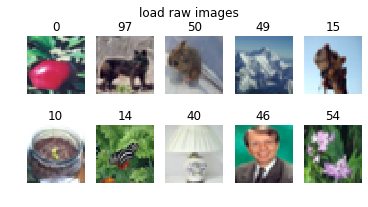

In [164]:
max_images = len(testloader)
grid_width = 5
grid_height = int(max_images / grid_width)
# print(max_images, grid_width, grid_height, grid_width+1, grid_height+1)
# fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width+1, grid_height+1))
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width+1, grid_height+1))

label_list = []
for i, (im, label) in enumerate(testloader):
    label_list.append(label)
    # print(i, im.size(), label.size())
    im = normalize_invert(im, normMean, normStd)
    # print(i, im.size(), label.size())
    im = im.permute(0, 2, 3, 1)
    # print(i, im.size(), label.size())
    im = np.array(im * 255).clip(0, 255).squeeze().astype('uint8')
    # print(i, im.shape, label.size())
    # print(int(i / grid_width), i % grid_width)
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im)
    ax.set_title(str(label.item()))
    ax.axis('off')
plt.suptitle("load raw images")
plt.show()

### 更新feature map list (经过固定层的表达)

In [ ]:
                # record
                # layer1 bottleneck
                # handle = net.Block[0].conv_first[0][0].register_forward_hook(hook) # conv2d [1,64,32,32] -> [1,128,32,32]
                # handle = net.Block[0].conv_first[0][1].register_forward_hook(hook) # BatchNorm2d [1,64,32,32] -> [1,128,32,32]
                # handle = net.Block[0].conv_first[0][2].register_forward_hook(hook) # ReLU [1,64,32,32] -> [1,128,32,32] 
                # handle = net.Block[0].pool.register_forward_hook(hook) # [1, 128, 32, 32] -> [1, 128, 16, 16])
                
                # handle = net.Block[0].mix_conv[0][0].register_forward_hook(hook) # [1,128,16,16] -> [1,128,16,16]
                # handle = net.Block[0].mix_conv_2[0][0].register_forward_hook(hook) # [1,128,16,16] -> [1,128,16,16]

                # layer2 Block[1] Sequential
                # handle = net.Block[1][0].register_forward_hook(hook) # conv2d
                # handle = net.Block[1][1].register_forward_hook(hook) # BatchNorm2d
                # handle = net.Block[1][2].register_forward_hook(hook) ReLU [1, 256, 16, 16]
                # handle = net.Block[1][3].register_forward_hook(hook) # MaxPool2d

                # layer3
                # handle = net.Block[2].conv_first[0][0].register_forward_hook(hook)  # [1, 256, 8, 8]) [1, 512, 8, 8])
                # handle = net.Block[2].conv_first[0][1].register_forward_hook(hook)  # [1, 256, 8, 8]) [1, 512, 8, 8])
                
                # handle = net.Block[2].pool.register_forward_hook(hook)
                # handle = net.Block[2].mix_conv[0][0].register_forward_hook(hook)  # 这个位置是 relu [1, 512, 4, 4] [1, 512, 4, 4])
                # handle = net.Block[2].mix_conv_2[0][0].register_forward_hook(hook)

                # avgpool
                # handle = net.avgpool.register_forward_hook(hook)  # conv的input维度
                # output = net(img)
                # print(output.size())
                # vvv = hook_list
                # print(hook_list)
                # handle.remove()

In [181]:
def select_feature(i, batch_idx, vis_layer, net, img, numbers_images, architecture):
    """
    i: epoch 1,2
    batch_idx: images 1,2,3->99
    vis_layer: conv
    """
    if vis_layer == 'stem': 
        handle = net.stem.register_forward_hook(hook)
        output = net(img, architecture) # print(output.size())
        handle.remove()

    elif vis_layer == 'stem_1': 
        handle = net.stem[0].register_forward_hook(hook)
        output = net(img, architecture) # print(output.size())
        handle.remove()
        
    elif vis_layer == 'stem_2': 
        handle = net.stem[3].register_forward_hook(hook)
        output = net(img, architecture) # print(output.size())
        handle.remove()
        
    elif vis_layer == 'prep': 
        handle = net.prep.register_forward_hook(hook)
        output = net(img) # print(output.size())
        handle.remove()
        
    elif vis_layer == 'layer1_bottleneck': # ([1, 64, 32, 32]) torch.Size([1, 128, 16, 16])
        handle = net.Block[0].register_forward_hook(hook)
        output = net(img) # print(output.size())
        handle.remove()

    elif vis_layer == 'layer2_bottleneck':  # [1, 128, 16, 16]) torch.Size([1, 256, 8, 8]
        handle = net.Block[1].register_forward_hook(hook)
        output = net(img)  # print(output.size())
        handle.remove()

    elif vis_layer == 'layer3_bottleneck':  # [1, 256, 8, 8]) torch.Size([1, 512, 4, 4]
        handle = net.Block[2].register_forward_hook(hook)
        output = net(img)  # print(output.size())
        handle.remove()

    elif vis_layer == 'avgpool':  # [1, 512, 4, 4]) torch.Size([1, 512, 1, 1]
        handle = net.avgpool.register_forward_hook(hook)
        output = net(img)  # print(output.size())
        handle.remove()

    elif vis_layer == 'layer2_MaxPool2d':
        handle = net.Block[1][3].register_forward_hook(hook)
        output = net(img, architecture) # print(output.size())
        handle.remove()
        
    elif vis_layer == 'layer3_mix_conv':
        handle = net.Block[2].mix_conv[0][0].register_forward_hook(hook)
        output = net(img, architecture) # print(output.size())
        handle.remove()

    elif vis_layer == 'layer3_mix_conv_2':
        handle = net.Block[2].mix_conv_2[0][0].register_forward_hook(hook)
        output = net(img, architecture) # print(output.size())
        handle.remove()

    # before / after 
    # print((i-1)*numbers_images*2 + batch_idx * 2, (i-1)*numbers_images*2  + batch_idx * 2 + 1)
    tensor_size = list(hook_list[(i-1)*numbers_images*2  + batch_idx * 2].size())
    if tensor_size[1]!=3:
        hook_list[(i-1)*numbers_images*2  + batch_idx * 2] = torch.mean(hook_list[(i-1)*numbers_images*2  + batch_idx*2], dim=1, keepdim=False, out=None)
        hook_list[(i-1)*numbers_images*2  + batch_idx * 2 + 1] = torch.mean(hook_list[(i-1)*numbers_images*2  + batch_idx*2+1], dim=1, keepdim=False, out=None)
    else:
        hook_list[(i-1)*numbers_images*2  + batch_idx * 2] = torch.mean(hook_list[(i-1)*numbers_images*2  + batch_idx*2], dim=0, keepdim=False, out=None)
        hook_list[(i-1)*numbers_images*2  + batch_idx * 2 + 1] = torch.mean(hook_list[(i-1)*numbers_images*2  + batch_idx*2+1], dim=0, keepdim=False, out=None)
        
    hook_list[(i-1)*numbers_images*2  + batch_idx * 2] = hook_list[(i-1)*numbers_images*2  + batch_idx * 2].unsqueeze(0)
    hook_list[(i-1)*numbers_images*2  + batch_idx * 2 + 1] = hook_list[(i-1)*numbers_images*2  + batch_idx * 2 + 1].unsqueeze(0)
    return hook_list
    
    # hook_list[batch_idx * 2] = torch.cat((hook_list[batch_idx * 2], hook_list[batch_idx * 2]), 0)
    # hook_list[batch_idx * 2 + 1] = torch.cat((hook_list[batch_idx * 2 + 1], hook_list[batch_idx * 2 + 1]), 0)
    # hook_list[batch_idx * 2] = torch.stack([hook_list[batch_idx * 2], hook_list[batch_idx * 2]], 1)

    # print(i) # 4epoch ,100images # 0-399
    # conv_before vs conv_after
    
    # img_grid_before = vutils.make_grid(hook_list[batch_idx*2], normalize=True, scale_each=True)  # B，C, H, W
    # writer.add_image('images{}_epoch{}_before_{}_feature_maps'.format(batch_idx, epoch, vis_layer), img_grid_before, global_step=666)


In [182]:
# multi-conv

hook_list = []
def hook(module, input, output):
    hook_list.append(input[0])
    hook_list.append(output)

different_conv = {}

# vis_layer_list = ['stem', 'layer1_bottleneck', 'layer2_bottleneck', 'layer3_bottleneck', 'avgpool']
# vis_layer_list = ['stem','layer3_mix_conv']
vis_layer_list = ['stem_1', 'stem_2', 'layer3_mix_conv', 'layer3_mix_conv_2']
# vis_layer_list = ['layer3_mix_conv']

for k in vis_layer_list:
    vis_layer = k
    # epoch ->
    start_epoch = 90
    period = 10
    current_lr_list = {}
    hook_list = []
    #for i in range(start_epoch,start_epoch+period):
    #    epoch=str(i)
    for i in range(1,1+period):
        epoch=str(start_epoch+i-1)
        net, current_lr = load_parameters(epoch)
        current_lr_list.update(current_lr)
        if Flops_counter:
            counter(net)
        elif Record_feature:
            net.apply(record_feature)
        elif Write_forward:
            pass
        elif Write_layer: # According to specific layer
            # cifar100: 100images
            for batch_idx, (inputs, targets) in enumerate(testloader):
                img, label = inputs.to(device), targets.to(device)
                x = img
                # print('images{}_epoch{}_before_{}_feature_maps'.format(batch_idx, epoch, vis_layer))
                """
                if i==1:
                    # write img_raw
                    img_raw = normalize_invert(img, normMean, normStd)
                    img_raw = np.array(img_raw * 255).clip(0, 255).squeeze().astype('uint8')
                    # writer.add_image('0_images{}_input_raw_img'.format(batch_idx), img_raw, global_step=666)
                    # save
                    img_raw = img_raw.transpose(2,1,0)
                    im = Image.fromarray(img_raw)
                    im.save('/home/ubuntu/workspace/nni_sy/examples/trials/pytorch_tensorboard_Analysis/cifar10_10_layer_wise_7_3_d_5_vis/feature_map/images_folder/images_{}.png'.format(batch_idx))    
                """
                fearure_list = select_feature(i, batch_idx, vis_layer, net, img, len(testloader), architecture)
    print('{}: Sample:{}, Period:{}->{}, Feature_size:{}->{}'.format(vis_layer, len(testloader), start_epoch, start_epoch+period, fearure_list[0].size(), fearure_list[1].size()))
    
    temp_feature_list = {k: fearure_list}
    different_conv.update(temp_feature_list)
    print(current_lr_list.keys())
print(different_conv.keys())

['./checkpoint/exp2_90_net_params_loc0_6.41e-05_loc8_3.38e-04.pkl']
[3, 3]
[3, 3]
['./checkpoint/exp2_91_net_params_loc0_5.09e-05_loc8_2.69e-04.pkl']
[3, 3]
[3, 3]
['./checkpoint/exp2_92_net_params_loc0_3.88e-05_loc8_2.05e-04.pkl']
[3, 3]
[3, 3]
['./checkpoint/exp2_93_net_params_loc0_2.80e-05_loc8_1.48e-04.pkl']
[3, 3]
[3, 3]
['./checkpoint/exp2_94_net_params_loc0_1.87e-05_loc8_9.89e-05.pkl']
[3, 3]
[3, 3]
['./checkpoint/exp2_95_net_params_loc0_1.12e-05_loc8_5.92e-05.pkl']
[3, 3]
[3, 3]
['./checkpoint/exp2_96_net_params_loc0_5.61e-06_loc8_2.96e-05.pkl']
[3, 3]
[3, 3]
['./checkpoint/exp2_97_net_params_loc0_1.99e-06_loc8_1.04e-05.pkl']
[3, 3]
[3, 3]
['./checkpoint/exp2_98_net_params_loc0_2.89e-07_loc8_1.48e-06.pkl']
[3, 3]
[3, 3]
['./checkpoint/exp2_99_net_params_loc0_1.00e-08_loc8_1.00e-08.pkl']
[3, 3]
[3, 3]
stem_1: Sample:10, Period:90->100, Feature_size:torch.Size([1, 3, 32, 32])->torch.Size([1, 64, 32, 32])
dict_keys(['90', '91', '92', '93', '94', '95', '96', '97', '98', '99'])
['./

### feature map 可视化

In [50]:
for index, (im, label) in enumerate(zip(single_before_feature, zip_label_list)):
    # print(index, im.shape, label.size(), label[0])
    index, im.shape, label.size(), label[0]

NameError: name 'single_before_feature' is not defined

row:10,column:10


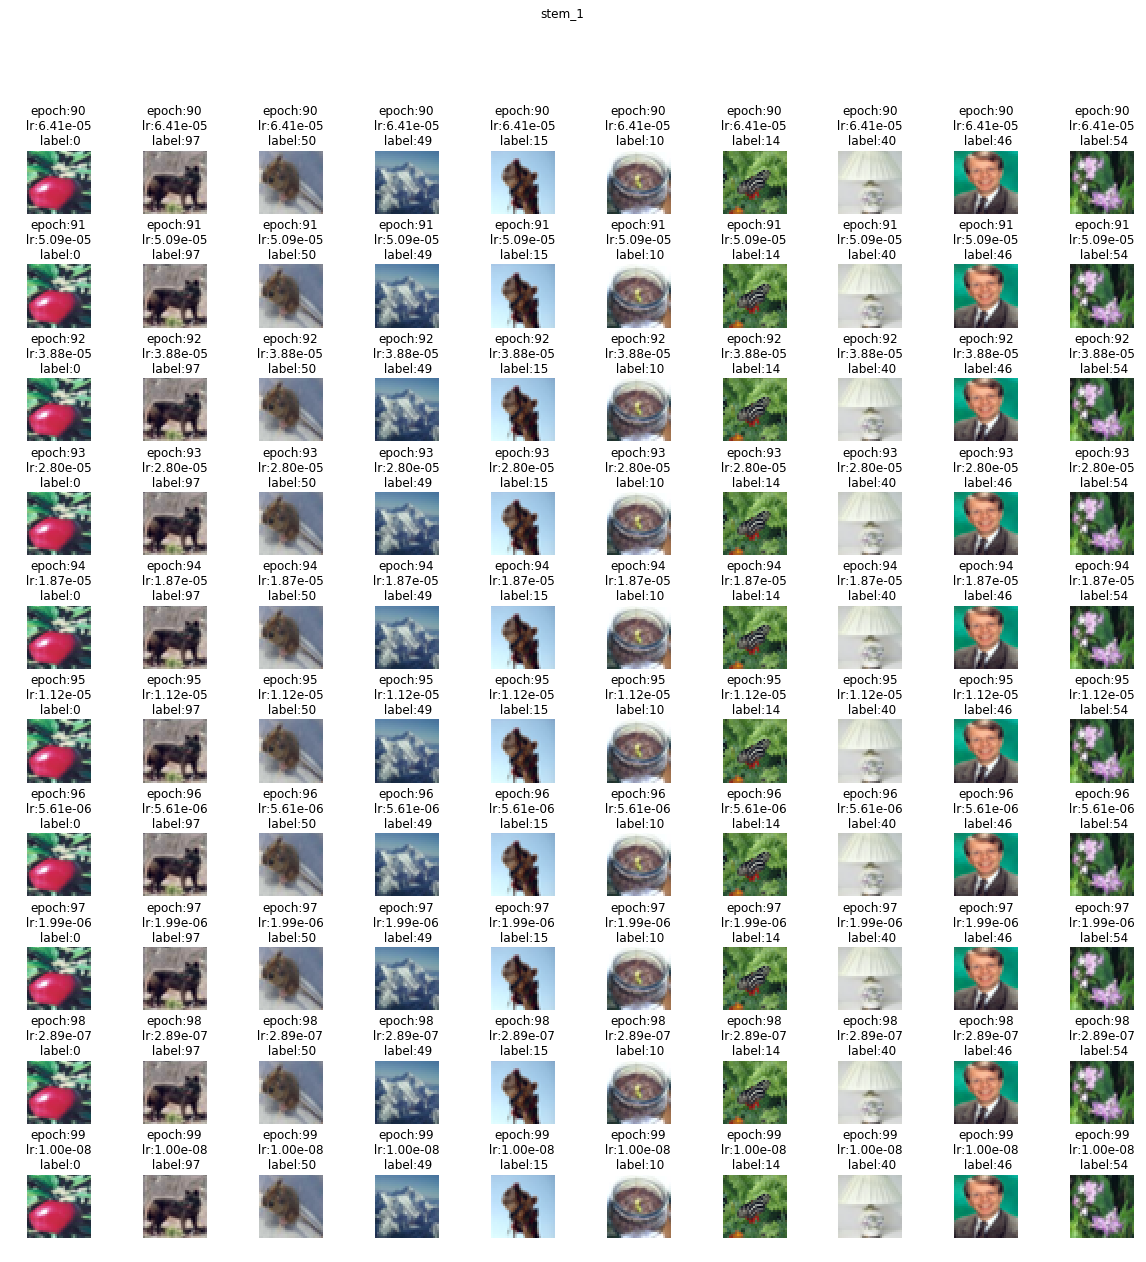

row:10,column:10


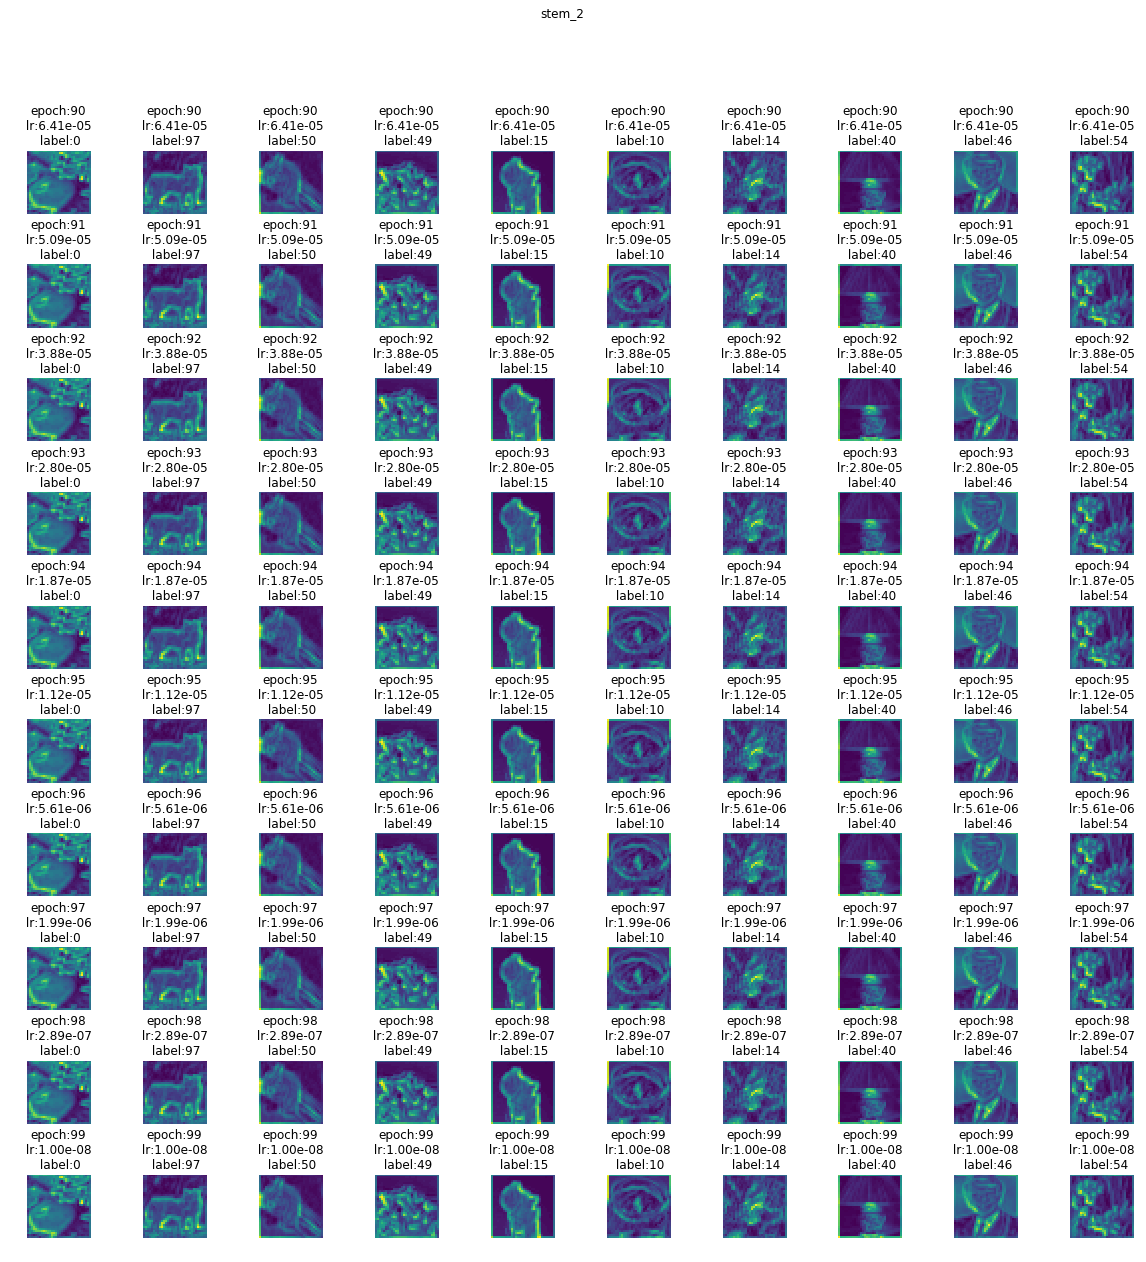

row:10,column:10


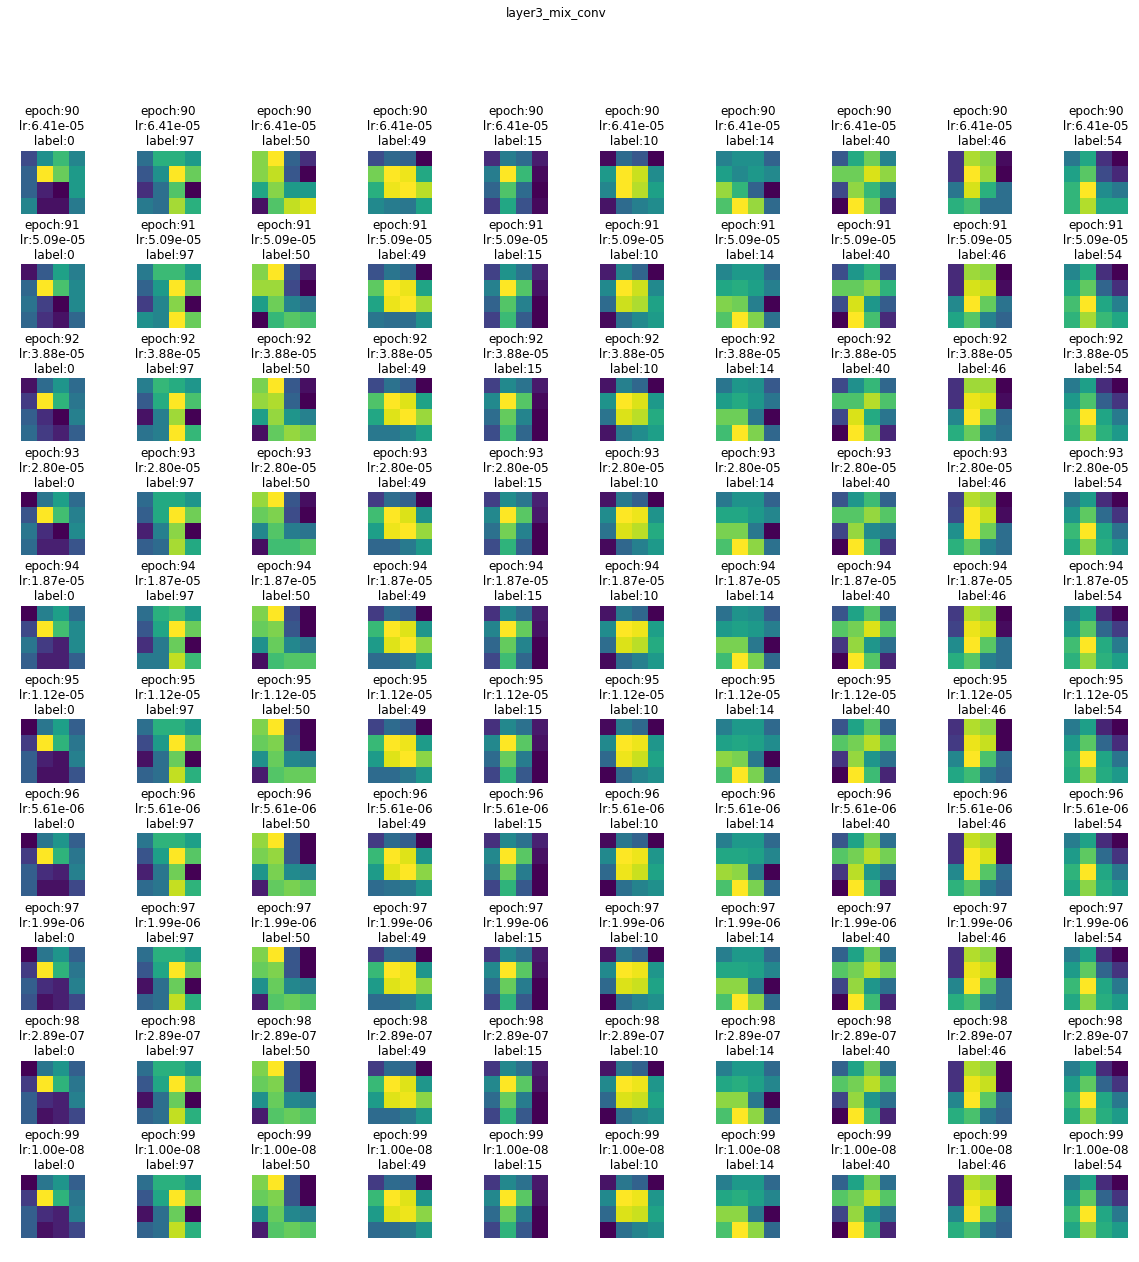

row:10,column:10


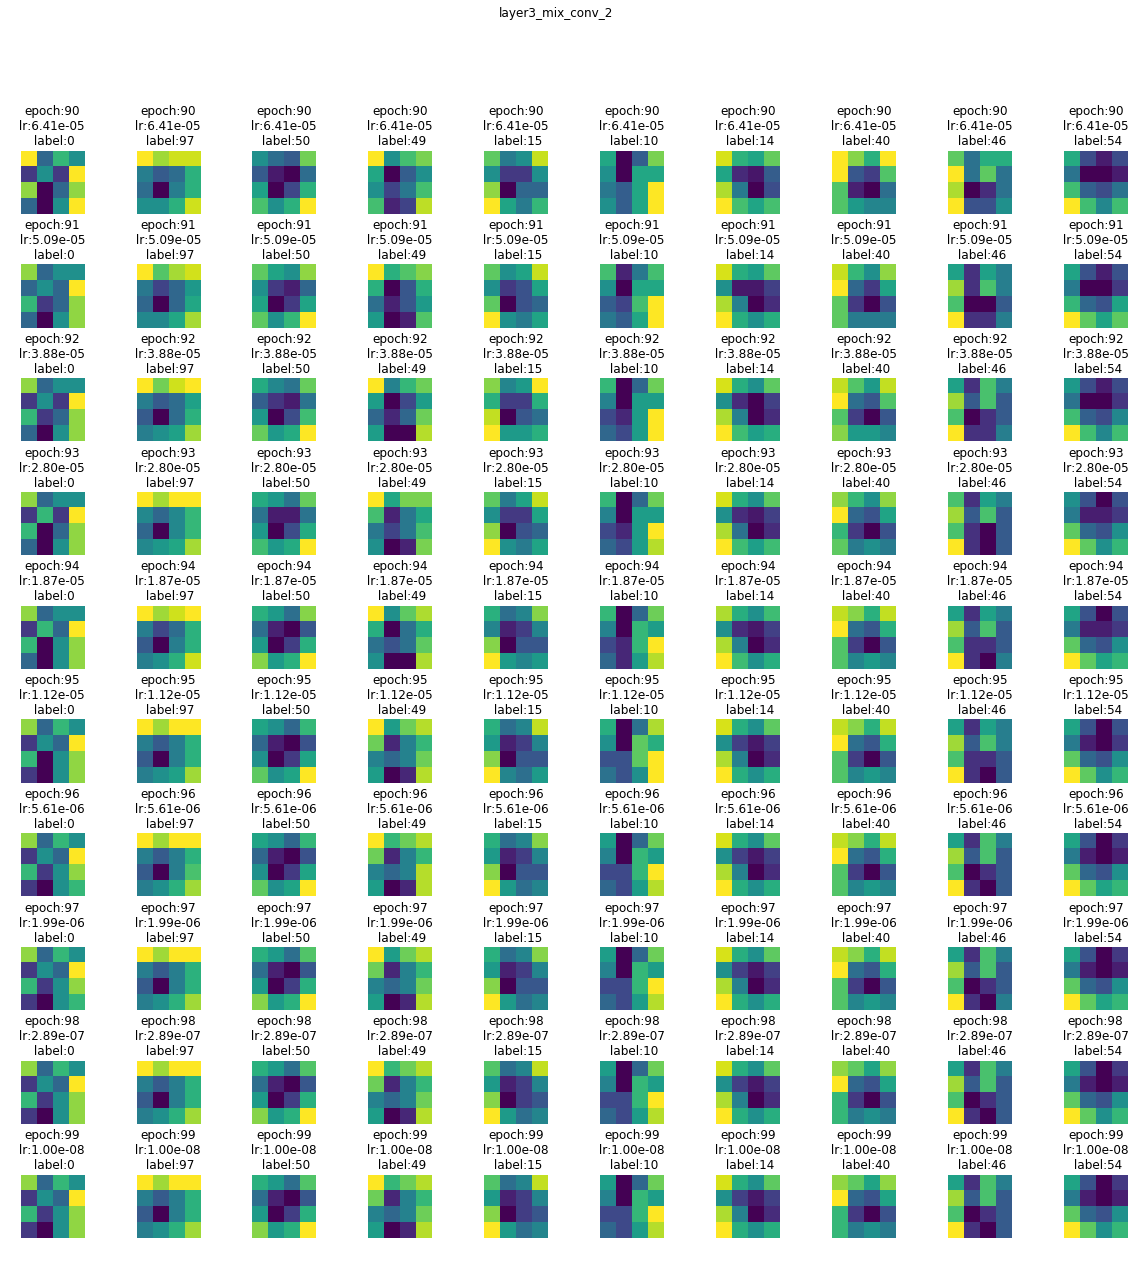

In [183]:
# multi

for w in different_conv.keys():
    fearure_list = different_conv[w]
    
    epoch = int(period)
    # zip_label_list = [val for val in label_list for i in range(epoch)]
    zip_label_list = label_list * epoch
    # print(len(zip_label_list))

    # plot
    max_images = 10 * epoch
    grid_width = 10
    grid_height = int(max_images / grid_width)

    # before conv
    number_feature = len(fearure_list) // 2
    single_before_feature = [fearure_list[2*i] for i in range(number_feature)]

    # after conv
    single_after_feature = [fearure_list[2*i+1] for i in range(number_feature)]
    # print(len(single_before_feature))

    # print(len(single_before_feature), len(zip_label_list))
    # print(single_before_feature[0].size(), zip_label_list[0].size())
    # print(current_lr_list)
    print('row:{},column:{}'.format(grid_height, grid_width))

    fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width+10, grid_height+10))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=0.8)
    
    xx = single_after_feature
    # xx = single_before_feature 
    # before feature
    for index, (im, label) in enumerate(zip(xx, zip_label_list)):
    # for index in range(number_feature):
        # print(index*2, index*2+1)
        # print(i, im.size(), label.size())
        im = fearure_list[index*2]
        im = normalize_invert(im, normMean, normStd)
        im = im.permute(0, 2, 3, 1)
        im = im.detach()
        # im = np.array(im * 255).clip(0, 255).astype('uint8')
        # print(index, im.shape, label.size())
        im = np.array(im * 255).clip(0, 255).squeeze().astype('uint8')
        im = im.squeeze()
        # print(index, im.size(), label.size())
        # im = im.unsqueeze(2)
        # im = np.array(im * 255)
        # print(current_lr_list[str(index//10+1)], index//10, index, im.shape, label.size())
        ax = axs[int(index / grid_width), index % grid_width]
        # ax.imshow(im.squeeze())
        ax.imshow(im)
 
        # print(index//10+start_epoch, float(current_lr_list[str(index//10+start_epoch)]), str(label.item()))
        ax.set_title('epoch:{}\n lr:{} \n label:{}'.format(index//10+start_epoch, str(current_lr_list[str(index//10+start_epoch)]), str(label.item())))
        # print(index//10+start_epoch, float(current_lr_list[str((index+start_epoch)//10+1)]))
        # ax.set_title('{}:{:.4f}'.format(index//10+start_epoch, float(current_lr_list[str((index+start_epoch)//100+1)])))
        
        ax.axis('off')
    plt.suptitle(w)
    plt.show()

In [112]:
# 查看cosine_lr
print(current_lr_list)
print(xx[0].size())
print(xx[1])

{'1': '3.83e-05', '2': '3.67e-05', '3': '3.46e-05', '4': '3.22e-05', '5': '2.95e-05', '6': '2.66e-05', '7': '2.36e-05', '8': '2.04e-05', '9': '1.73e-05', '10': '1.42e-05'}
torch.Size([1, 1, 4, 4])
tensor([[[[0.3935, 0.3940, 0.3928, 0.3571],
          [0.3433, 0.4242, 0.4470, 0.4189],
          [0.3473, 0.4374, 0.4357, 0.4222],
          [0.4034, 0.4600, 0.4649, 0.3919]]]], grad_fn=<UnsqueezeBackward0>)


In [41]:
!nvidia-smi

Mon May 18 14:03:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P0    41W / 300W |   1133MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### 查看单一的conv

In [59]:
# single conv

hook_list = []
def hook(module, input, output):
    hook_list.append(input[0])
    hook_list.append(output)
    # print(len(hook_list), input[0].size(), output.size())

# writer = SummaryWriter(log_dir='./feature_map/')

# vis_layer = 'avgpool'
vis_layer = 'layer1_bottleneck'
# vis_layer = 'layer2_bottleneck'
# vis_layer = 'layer3_bottleneck'

# epoch ->
start_epoch = 1
period = 20
current_lr_list = {}
for i in range(start_epoch,start_epoch+period):
    epoch=str(i)
    net, current_lr = load_parameters(epoch)
    current_lr_list.update(current_lr)
    if Flops_counter:
        counter(net)
    elif Record_feature:
        net.apply(record_feature)
    elif Write_forward:
        pass
    elif Write_layer: # According to specific layer
        # cifar100: 100images
        for batch_idx, (inputs, targets) in enumerate(testloader):
            img, label = inputs.to(device), targets.to(device)
            x = img
            # print('images{}_epoch{}_before_{}_feature_maps'.format(batch_idx, epoch, vis_layer))
            """
            if i==1:
                # write img_raw
                img_raw = normalize_invert(img, normMean, normStd)
                img_raw = np.array(img_raw * 255).clip(0, 255).squeeze().astype('uint8')
                # writer.add_image('0_images{}_input_raw_img'.format(batch_idx), img_raw, global_step=666)
                # save
                img_raw = img_raw.transpose(2,1,0)
                im = Image.fromarray(img_raw)
                im.save('/home/ubuntu/workspace/nni_sy/examples/trials/pytorch_tensorboard_Analysis/cifar10_10_layer_wise_7_3_d_5_vis/feature_map/images_folder/images_{}.png'.format(batch_idx))    
            """
            fearure_list = select_feature(i, batch_idx, vis_layer, net, img, len(testloader))
print('{}: Sample:{}, Period:{}->{}, Feature_size:{}->{}'.format(vis_layer, len(testloader), start_epoch, start_epoch+period, fearure_list[0].size(), fearure_list[1].size()))


layer1_bottleneck:Sample:10, Period:1->21, Feature_size:torch.Size([1, 1, 32, 32])->torch.Size([1, 1, 16, 16])


row:20,column:10


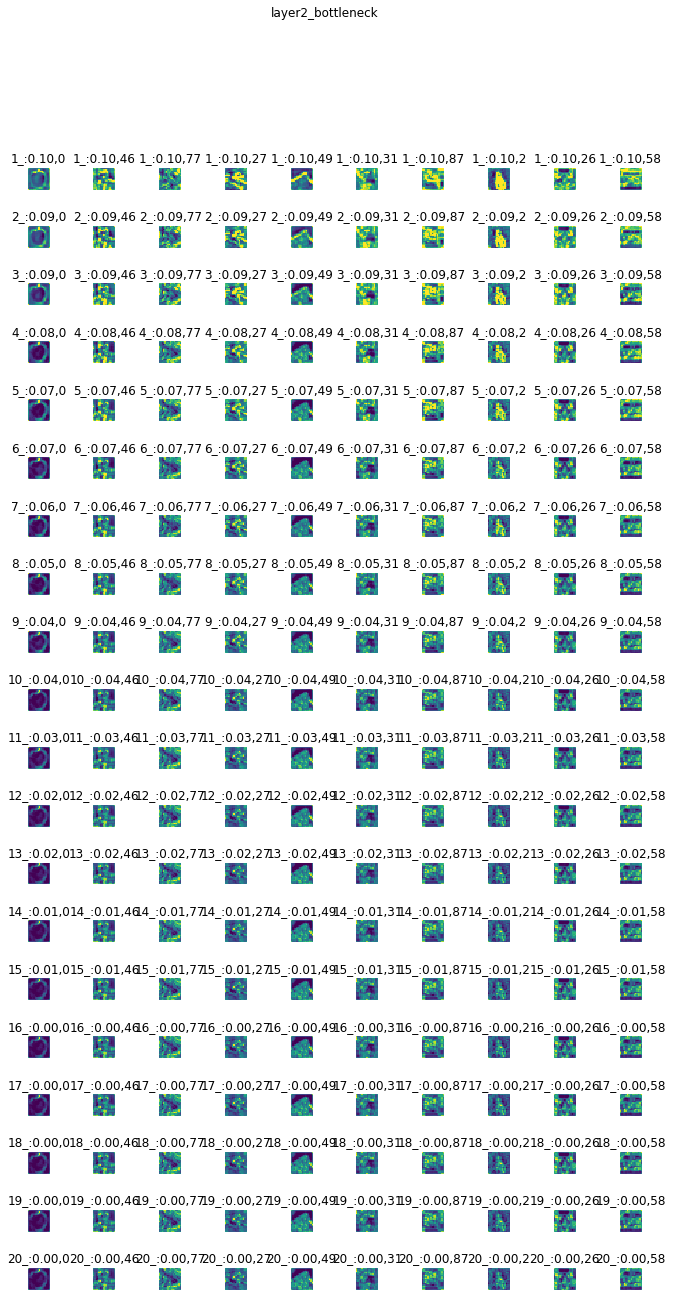

In [17]:
# single

epoch = int(period)
# zip_label_list = [val for val in label_list for i in range(epoch)]
zip_label_list = label_list * epoch
# print(len(zip_label_list))

# plot
max_images = 10 * epoch
grid_width = 10
grid_height = int(max_images / grid_width)

# before conv
number_feature = len(fearure_list) // 2
single_before_feature = [fearure_list[2*i] for i in range(number_feature)]

# after conv
# single_after_feature = [fearure_list[2*i+1] for i in range(number_feature)]
# print(len(single_before_feature))

# print(len(single_before_feature), len(zip_label_list))
# print(single_before_feature[0].size(), zip_label_list[0].size())
# print(current_lr_list)
print('row:{},column:{}'.format(grid_height, grid_width))

fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width+1, grid_height+1))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=2.0, hspace=0.4)
# before feature
for index, (im, label) in enumerate(zip(single_before_feature, zip_label_list)):
# for index in range(number_feature):
    # print(index*2, index*2+1)
    # print(i, im.size(), label.size())
    # im = normalize_invert(im, normMean, normStd)
    im = fearure_list[index*2]
    im = im.permute(0, 2, 3, 1)
    im = im.detach()
    # im = np.array(im * 255).clip(0, 255).astype('uint8')
    # print(index, im.shape, label.size())
    im = np.array(im * 255).clip(0, 255).squeeze().astype('uint8')
    im = im.squeeze()
    # print(index, im.size(), label.size())
    # im = im.unsqueeze(2)
    # im = np.array(im * 255)
    # print(current_lr_list[str(index//10+1)], index//10, index, im.shape, label.size())
    ax = axs[int(index / grid_width), index % grid_width]
    # ax.imshow(im.squeeze())
    ax.imshow(im)
    ax.set_title('{}_:{:.2f},{}'.format(index//10+start_epoch, float(current_lr_list[str(index//10+1)]), str(label.item())))
    ax.axis('off')
plt.suptitle(vis_layer)
plt.show()

In [40]:
!nvidia-smi

Mon May 18 14:03:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   34C    P0    41W / 300W |   1133MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [107]:
import os, glob, re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

print(sns.__version__)

# 最大数
def Get_Max(list):
    return max(list)

# 最小数
def Get_Min(list):
    return min(list)

# 极差
def Get_Range(list):
    return max(list) - min(list)

# 中位数
def get_median(data):
    data = sorted(data)
    size = len(data)
    if size % 2 == 0:
        # 判断列表长度为偶数
        median = (data[size // 2] + data[size // 2 - 1]) / 2
    if size % 2 == 1:
        # 判断列表长度为奇数
        median = data[(size - 1) // 2]
    return median

# 众数(返回多个众数的平均值)
def Get_Most(list):
    most = []
    item_num = dict((item, list.count(item)) for item in list)
    for k, v in item_num.items():
        if v == max(item_num.values()):
            most.append(k)
    return sum(most) / len(most)

# 获取平均数
def Get_Average(list):
    sum = 0
    for item in list:
        sum += item
    return sum / len(list)

### 如果把文件指针移动到靠后的位置，那么只要readlines方法返回的list的长度大于2，那么虽然list第一个元素读取的行可能不完整，但后面的元素读取的行肯定都是完整的了。而且考虑到了最后一行或多行是空行的情况。
def get_last_line(inputfile):
    filesize = os.path.getsize(inputfile)
    blocksize = 1024
    dat_file = open(inputfile, 'rb')

    last_line = b""
    lines = []
    if filesize > blocksize:
        maxseekpoint = (filesize // blocksize)  # 这里的除法取的是floor
        maxseekpoint -= 1
        dat_file.seek(maxseekpoint * blocksize)
        lines = dat_file.readlines()
        while ((len(lines) < 2) | ((len(lines) >= 2) & (lines[1] == b'\r\n'))):  # 因为在Windows下，所以是b'\r\n'
            # 如果列表长度小于2，或者虽然长度大于等于2，但第二个元素却还是空行
            # 如果跳出循环，那么lines长度大于等于2，且第二个元素肯定是完整的行
            maxseekpoint -= 1
            dat_file.seek(maxseekpoint * blocksize)
            lines = dat_file.readlines()
    elif filesize:  # 文件大小不为空
        dat_file.seek(0, 0)
        lines = dat_file.readlines()
    if lines:  # 列表不为空
        for i in range(len(lines) - 1, -1, -1):
            last_line = lines[i].strip()
            if (last_line != b''):
                break  # 已经找到最后一个不是空行的
    dat_file.close()
    return last_line

def describe_lr(df):
    # df.describe()
    # print(df)
    print(df.shape)
    # print(df.describe())
    
def read_cfg(exp_list):
    metrics_list = []
    # DataFrame
    df = [] 
    df = pd.DataFrame(df)

    for exp in exp_list:
        # for file in file_list:         # print("-"*80)
        params_path = os.path.join(exp, 'parameter.cfg') # print(params_path)
        _in_file = open(params_path, 'rb')
        header = _in_file.read(0) # if header is None or len(header) < 8:
        data = _in_file.read(-1) # class 'bytes'
        data = data.decode('utf8') # str
        info = eval(data) # dict
        
        # extracting hyper-parameters information
        hyper_p = info["parameters"]
        insert = pd.DataFrame.from_dict(hyper_p, orient='index', columns=[str(info["parameter_id"])])
        # print(insert)
        
        # extracting metrics
        file = exp + "/.nni/metrics" # midname = file[file.rindex("/") + 1:]
        last = get_last_line(file) # 该函数返回的是bytes
        last = last.decode()
        a = last.split('"')[-2]
        b = last.split('"')[-8]
        if float(a) > 0.0 and b=='FINAL':
            insert.loc['metrics'] = float(a) # 
            metrics_list.append(float(a))
        
        df = pd.concat([df,insert], axis=1, sort=False)
    return df, metrics_list

0.10.0


In [108]:
def process(df, target_conv=False, top20=False, distance4=False):
    
    if distance4:
        # print(df.loc['metrics'].max())
        df = df.sort_values(by=['metrics'], axis=1, ascending=False)
        # df = df.loc[:, df.loc['metrics'] > df.loc['metrics'].max()-4]
        df = df.loc[:, df.loc['metrics'] > 5]
        df = df.loc[:, df.loc['metrics'] <= df.loc['metrics'].max()]
        # print(df)
    elif top20:
        df = df.sort_values(by=['metrics'], axis=1, ascending=False)
        df = df.iloc[:, 0:40] 
        # print(df)

    # df = df.drop(index=['metrics'])

    # 某个layer3_conv1_3_3
    # tb_layer3_conv1_3_3 = df.loc[['layer3_conv1_3_3'],['330','331']]
    tb_layer3_conv1_3_3 = df.loc[[target_conv, 'metrics'],:] 

    # 转置
    tb_layer3_conv1_3_3_r = pd.DataFrame(tb_layer3_conv1_3_3.values.T, index=tb_layer3_conv1_3_3.columns, columns=tb_layer3_conv1_3_3.index)

    # sort_index
    #tb_layer3_conv1_3_3_r = tb_layer3_conv1_3_3_r.sort_index(axis=0)
    #print(tb_layer3_conv1_3_3_r)

    # reset_index
    tb_layer3_conv1_3_3_r.reset_index(drop=True, inplace=True)
    # describe_lr(tb_layer3_conv1_3_3_r)
    return tb_layer3_conv1_3_3_r

In [109]:
def metrics_distribution(target_conv, metrics_list, tb_layer3_conv1_3_3_r, metrics_summary=False):
    if metrics_summary:
        fig, axes = plt.subplots(2, 1, figsize=(10, 12)) 
        # top
        # print(type(metrics_list))
        # print(metrics_list[0:6])
        sns.distplot(metrics_list, bins=30, hist=True, kde=True, rug=True,  # bins
                          hist_kws={'color': 'green', 'label': 'hist', 'label': 'hist'},
                          # hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"},
                          rug_kws={'color': 'y', 'lw': 2, 'alpha': 0.5, 'height': 0.1, 'label': 'rug'},
                          # 设置数据频率分布颜色#控制是否显示观测的小细条（边际毛毯）
                          kde_kws={"color": "r", "lw": 1.5, 'linestyle': '--', 'label': 'KDE'},
                          # 设置密度曲线颜色，线宽，标注、线形，#控制是否显示核密度估计图
                          ax=axes[0])
        # 绘制中位数辅助线
        hmedian = get_median(metrics_list)
        axes[0].axvline(hmedian, color='b', linestyle=":", alpha=0.8)
        axes[0].text(hmedian + 2, 0.008 , 'hmedian: %.1fcm' % (hmedian), color='b')
        # 绘制平均辅助线
        hmean = Get_Average(metrics_list)
        axes[0].axvline(hmean, color='g', linestyle=":", alpha=0.8)
        axes[0].text(hmean - 8, 0.008 , 'hmean: %.1fcm' % (hmean), color='g')

        axes[0].set(xlabel='Metric', ylabel='Frequency')
        axes[0].grid(linestyle='--')
        axes[0].set_ylim([0, 0.2])

        target = pd.Series(tb_layer3_conv1_3_3_r[target_conv], name=target_conv)
        sns.distplot(target, bins=30, hist=True, kde=True, rug=True, color="b", 
        # sns.distplot(tb_layer3_conv1_3_3_r['layer3_conv1_3_3'], kde=True, rug=True, color="b", 
                     rug_kws={'color': 'y', 'lw': 2, 'alpha': 0.5, 'height': 0.1, 'label': 'rug'},
                     kde_kws={"color": "r", "lw": 1.5, 'linestyle': '--', 'label': 'KDE'},
                     ax=axes[1])
    
        # axes[1] = sns.jointplot(x=tb_layer3_conv1_3_3_r.index, y='layer3_conv1_3_3', data=tb_layer3_conv1_3_3_r, kind='scatter');
        # axes[1].set_ylim([0, 15])
        # plt.ylim([0, 0.2])
        # plt.title("Distributions of observations within Metrics")  # 添加图表名  
        # axes[0].ylim([0, 0.2])
        # axes[0].title("Distributions of observations within Metrics")  # 添加图表名
    
    # bottom, pandas.plot
    # seabron api
    
    
    #     sns.jointplot(x=tb_layer3_conv1_3_3_r[target_conv], 
    #                   y=tb_layer3_conv1_3_3_r['metrics'], 
    #                   data=tb_layer3_conv1_3_3_r, 
    #                   color = 'red',
    #                   s = 50, edgecolor = 'w', linewidth = 1,#设置散点大小、边缘颜色及宽度(只针对scatter)
    #                   space = 0.1, #设置散点图和布局图的间距
    #                   height = 8, #图表大小(自动调整为正方形))
    #                   ratio = 5, #散点图与布局图高度比，整型
    #                   marginal_kws = dict(bins=20, rug =True), #设置柱状图箱数，是否设置rug
    #                   kind='scatter')
    
    # 
    g = sns.JointGrid(x = target_conv, y = 'metrics', data = tb_layer3_conv1_3_3_r)
    g = g.plot_joint(plt.scatter, color = 'g', s = 40, edgecolor = 'white') #绘制散点图
    plt.xlim([1e-5, 1e-1])
    plt.xscale('log')
    plt.grid(linestyle = '--')
    g.plot_marginals(sns.distplot, kde = True, color = 'g')   #绘制x，y直方图

    
    # pandas api
    #     tb_layer3_conv1_3_3_r.plot.scatter(x=target_conv, y='metrics', marker='x')

    #     del tb_layer3_conv1_3_3_r['metrics']
    #     tb_layer3_conv1_3_3_r.plot.kde()

    layer3_conv1_3_3  metrics
0           0.005426    74.47
1           0.003551    74.30
2           0.003931    74.13
3           0.005368    74.01
4           0.006058    73.99
5           0.004129    73.93
6           0.005539    73.87
7           0.003620    73.87
8           0.005317    73.82
9           0.002753    73.77
10          0.003242    73.75
11          0.003658    73.71
12          0.006221    73.71
13          0.009934    73.68
14          0.003921    73.66
15          0.004589    73.65
16          0.004008    73.65
17          0.005100    73.64
18          0.005825    73.64
19          0.004602    73.63
20          0.007897    73.53
21          0.005144    73.52
22          0.014588    73.52
23          0.004244    73.49
24          0.004187    73.49
25          0.020579    73.48
26          0.008575    73.47
27          0.003427    73.46
28          0.001707    73.45
29          0.004074    73.45
30          0.000875    73.45
31          0.002822    73.44
32        

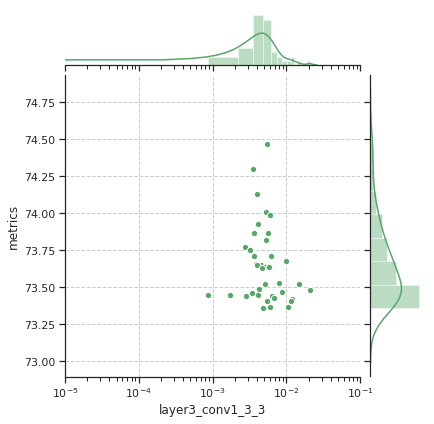

In [116]:
# layer-wise learning exp

experiment = '/home/ubuntu/nni/experiments/c94P3uVJ'
exp_list = glob.glob(os.path.join(experiment, "trials/*"))

# experiment = '/home/ubuntu/nni/experiments/YM7QxROb'
# experiment = '/home/ubuntu/nni/experiments/plot_P8'
# vim [exp_id]/trials/[trials_id]/.nni/metrics

# read_cfg
df, metrics_list = read_cfg(exp_list)

# summary
# describe_lr(df)

# select metrics_range
target_conv ='layer3_conv1_3_3'
tb_layer3_conv1_3_3_r = process(df, target_conv, top20=True, distance4=False) # (20, 1)  
# tb_layer3_conv1_3_3_r = process(df, target_conv='layer3_conv1_3_3', top20=False, distance4=True) # 1 ->10*26, (26, 1)
print(tb_layer3_conv1_3_3_r)

# plot analysis

metrics_distribution(target_conv, metrics_list, tb_layer3_conv1_3_3_r)



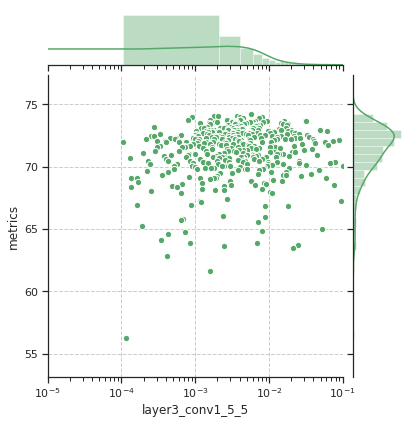

In [114]:
# layer-wise learning exp

experiment = '/home/ubuntu/nni/experiments/iZl44ACk'
exp_list = glob.glob(os.path.join(experiment, "trials/*"))

# experiment = '/home/ubuntu/nni/experiments/YM7QxROb'
# experiment = '/home/ubuntu/nni/experiments/plot_P8'
# vim [exp_id]/trials/[trials_id]/.nni/metrics

# read_cfg
df, metrics_list = read_cfg(exp_list)

# summary
# describe_lr(df)

# select metrics_range
target_conv ='layer3_conv1_5_5'
# tb_layer3_conv1_3_3_r = process(df, target_conv, top20=True, distance4=False) # (20, 1)  
tb_layer3_conv1_3_3_r = process(df, target_conv='layer3_conv1_5_5', top20=False, distance4=True) # 1 ->10*26, (26, 1)
# print(tb_layer3_conv1_3_3_r)

# plot analysis

metrics_distribution(target_conv, metrics_list, tb_layer3_conv1_3_3_r)


In [175]:
def metrics_distribution(metrics_list, tb_layer3_conv1_3_3_r):
    # single  
    plt.figure(figsize=(12, 8))  # 绘制画布
    ax = sns.distplot(metrics_list, bins=30, hist=True, kde=True, rug=True,  # bins
                      hist_kws={'color': 'green', 'label': 'hist', 'label': 'hist'},
                      # hist_kws={"histtype": "step", "linewidth": 3, "alpha": 1, "color": "g"},
                      rug_kws={'color': 'y', 'lw': 2, 'alpha': 0.5, 'height': 0.1, 'label': 'rug'},
                      # 设置数据频率分布颜色#控制是否显示观测的小细条（边际毛毯）
                      kde_kws={"color": "r", "lw": 1.5, 'linestyle': '--', 'label': 'KDE'})
                      # 设置密度曲线颜色，线宽，标注、线形，#控制是否显示核密度估计图
    
    ax.set(xlabel='Metric', ylabel='Frequency')
    # 绘制中位数辅助线
    hmedian = get_median(metrics_list)
    plt.axvline(hmedian, color='b', linestyle=":", alpha=0.8)
    plt.text(hmedian + 2, 0.008 , 'hmedian: %.1fcm' % (hmedian), color='b')

    # 绘制平均辅助线
    hmean = Get_Average(metrics_list)
    plt.axvline(hmean, color='g', linestyle=":", alpha=0.8)
    plt.text(hmean - 8, 0.008 , 'hmean: %.1fcm' % (hmean), color='g')

    plt.ylim([0, 0.2])
    # plt.grid(which='major')
    plt.grid(linestyle='--')  # 添加网格线
    plt.title("Distributions of observations within Metrics")  # 添加图表名

    print('num of trials: %d, mean: %.1f, median: %.1f' % (len(metrics_list), hmean, hmedian))
    


    # 绘制分布密度图
    # compare
    # hist
    # sns.distplot(tb_layer3_conv1_3_3_r, kde=True, ax=axes[1])
    
    # sns.lineplot(data=tb_layer3_conv1_3_3_r)
    # sns.jointplot(x="x", y="y", data=df, kind='scatter');
    # sns.jointplot(x="330" ,y="440", data=df, kind='scatter');
    # sns.set()
    # sns.lineplot(x="x", y="y", data=df)
    # sns.lineplot(x='430', y="420", data=df)
    
    # sns.pairplot(data=iris, hue="species");
    
    # scatter 
    # sns.jointplot(x=tb_layer3_conv1_3_3_r.index, y="layer3_conv1_3_3", data=tb_layer3_conv1_3_3_r, kind='scatter')
    # sns.jointplot(x=tb_layer3_conv1_3_3_r.index, y="layer3_conv1_3_3", data=tb_layer3_conv1_3_3_r,  kind='kde')
    # sns.jointplot(x=tb_layer3_conv1_3_3_r.index, y="layer3_conv1_3_3", data=tb_layer3_conv1_3_3_r,  kind='hex')
    plt.show()


起始点为(0.9451028585040586, 0.3722254632862951)
第1次迭代后,坐标为(0.7560822868032469, -0.2977803706290361)
第2次迭代后,坐标为(0.5878539779895244, 0.1779237714508492)
第3次迭代后,坐标为(0.45514263459838455, -0.09952564437348971)
第4次迭代后,坐标为(0.35217008677350503, 0.05465006807460129)
第5次迭代后,坐标为(0.2724685401145649, -0.029844240339352845)
第6次迭代后,坐标为(0.2108016928923473, 0.016270904514226407)
第7次迭代后,坐标为(0.16309133806387824, -0.008866360574558994)
第8次迭代后,坐标为(0.12617913851654036, 0.004830734601656511)
第9次迭代后,坐标为(0.09762121285397188, -0.0026318491154658143)
第10次迭代后,坐标为(0.07552675697354634, 0.0014338467578316428)
第11次迭代后,坐标为(0.05843290454959878, -0.0007811647776685433)
第12次迭代后,坐标为(0.04520787692152374, 0.00042558078393981785)
第13次迭代后,坐标为(0.03497604905069224, -0.0002318575266071017)
第14次迭代后,坐标为(0.027059974732178953, 0.00012631657333645867)
第15次迭代后,坐标为(0.020935533097076967, -6.881758967424651e-05)


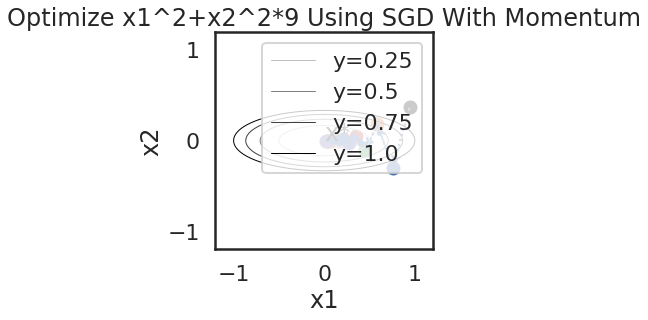

<Figure size 2880x2880 with 0 Axes>

第1次迭代后,坐标为(-0.05489714096689813, -0.6277745365644523)
第2次迭代后,坐标为(0.0033821503582623785, 0.23351112277389685)
第3次迭代后,坐标为(-0.00022643531811030685, -0.07297669963002962)
第4次迭代后,坐标为(1.6376972845884085e-05, 0.02284617852816044)
第5次迭代后,坐标为(-1.2729386315220901e-06, -0.00728968672861088)
第6次迭代后,坐标为(1.0585342307793279e-07, 0.0023739609415364665)


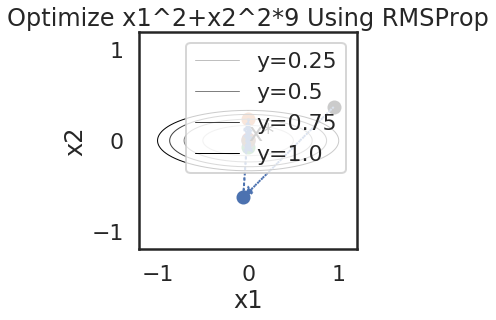

<Figure size 2880x2880 with 0 Axes>

第1次迭代后,坐标为(0.8451028585093491, 0.2722254632877876)
第2次迭代后,坐标为(0.7455241795366011, 0.17414036786892823)
第3次迭代后,坐标为(0.64673199309876, 0.08049228189059855)
第4次迭代后,坐标为(0.5491697724907127, -0.004778068200376934)
第5次迭代后,坐标为(0.45337187374729193, -0.07648614597116807)
第6次迭代后,坐标为(0.35997469962876655, -0.12970089772109322)
第7次迭代后,坐标为(0.26972360246767924, -0.16200857928987814)
第8次迭代后,坐标为(0.18347137288903176, -0.17432512963810912)
第9次迭代后,坐标为(0.10216314951616562, -0.16970733095707347)
第10次迭代后,坐标为(0.026802738150849548, -0.15185564981429311)
第11次迭代后,坐标为(-0.04160226243056378, -0.1243427182055931)
第12次迭代后,坐标为(-0.1021138656144263, -0.09043993382733917)
第13次迭代后,坐标为(-0.15394583403029688, -0.053186265250436245)
第14次迭代后,坐标为(-0.1965388415603755, -0.015480024971270968)
第15次迭代后,坐标为(-0.22961215448598932, 0.019914195220129174)


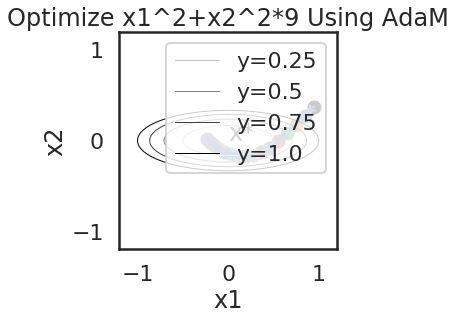

<Figure size 2880x2880 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [111]:
import math
import numpy as np
import matplotlib.pyplot as plt

RATIO = 3   # 椭圆的长宽比
LIMIT = 1.2 # 图像的坐标轴范围


class PlotComparaison(object):
    """多种优化器来优化函数 x1^2 + x2^2 * RATIO^2.
    每次参数改变为(d1, d2).梯度为(dx1, dx2)
    
    t+1次迭代,
    标准GD,
        d1_{t+1} = - eta * dx1
        d2_{t+1} = - eta * dx2
    带Momentum,
        d1_{t+1} = eta * (mu * d1_t - dx1_{t+1})
        d2_{t+1} = eta * (mu * d2_t - dx2_{t+1})    
    带Nesterov Momentum,
        d1_{t+1} = eta * (mu * d1_t - dx1^{nag}_{t+1})
        d2_{t+1} = eta * (mu * d2_t - dx2^{nag}_{t+1})
        其中(dx1^{nag}, dx2^{nag})为(x1 + eta * mu * d1_t, x2 + eta * mu * d2_t)处的梯度
    RMSProp,
        w1_{t+1} = beta2 * w1_t + (1 - beta2) * dx1_t^2
        w2_{t+1} = beta2 * w2_t + (1 - beta2) * dx2_t^2
        d1_{t+1} = - eta * dx1_t / (sqrt(w1_{t+1}) + epsilon)
        d2_{t+1} = - eta * dx2_t / (sqrt(w2_{t+1}) + epsilon)
    Adam,每次参数改变为(d1, d2)
        v1_{t+1} = beta1 * v1_t + (1 - beta1) * dx1_t
        v2_{t+1} = beta1 * v2_t + (1 - beta1) * dx2_t
        w1_{t+1} = beta2 * w1_t + (1 - beta2) * dx1_t^2
        w2_{t+1} = beta2 * w2_t + (1 - beta2) * dx2_t^2
        v1_corrected = v1_{t+1} / (1 - beta1^{t+1})
        v2_corrected = v2_{t+1} / (1 - beta1^{t+1})
        w1_corrected = w1_{t+1} / (1 - beta2^{t+1})
        w2_corrected = w2_{t+1} / (1 - beta2^{t+1})
        d1_{t+1} = - eta * v1_corrected / (sqrt(w1_corrected) + epsilon)
        d2_{t+1} = - eta * v2_corrected / (sqrt(w2_corrected) + epsilon)
    """

    def __init__(self, eta=0.1, mu=0.9, beta1=0.9, beta2=0.99, epsilon=1e-10, angles=None, contour_values=None,
                 stop_condition=1e-4):
        # 全部算法的学习率
        self.eta = eta

        # 启发式学习的终止条件
        self.stop_condition = stop_condition

        # Nesterov Momentum超参数
        self.mu = mu

        # RMSProp超参数
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        # 用正态分布随机生成初始点
        self.x1_init, self.x2_init = np.random.uniform(LIMIT / 2, LIMIT), np.random.uniform(LIMIT / 2, LIMIT) / RATIO
        self.x1, self.x2 = self.x1_init, self.x2_init

        # 等高线相关
        if angles == None:
            angles = np.arange(0, 2 * math.pi, 0.01)
        self.angles = angles
        if contour_values == None:
            contour_values = [0.25 * i for i in range(1, 5)]
        self.contour_values = contour_values
        setattr(self, "contour_colors", None)

    def draw_common(self, title):
        """画等高线,最优点和设置图片各种属性"""
        # 坐标轴尺度一致
        plt.gca().set_aspect(1)

        # 根据等高线的值生成坐标和颜色
        # 海拔越高颜色越深
        num_contour = len(self.contour_values)
        if not self.contour_colors:
            self.contour_colors = [(i / num_contour, i / num_contour, i / num_contour) for i in range(num_contour)]
            self.contour_colors.reverse()
            self.contours = [
                [
                    list(map(lambda x: math.sin(x) * math.sqrt(val), self.angles)),
                    list(map(lambda x: math.cos(x) * math.sqrt(val) / RATIO, self.angles))
                ]
                for val in self.contour_values
            ]

        # 画等高线
        for i in range(num_contour):
            plt.plot(self.contours[i][0],
                     self.contours[i][1],
                     linewidth=1,
                     linestyle='-',
                     color=self.contour_colors[i],
                     label="y={}".format(round(self.contour_values[i], 2))
                     )

        # 画最优点
        plt.text(0, 0, 'x*')

        # 图片标题
        plt.title(title)

        # 设置坐标轴名字和范围
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.xlim((-LIMIT, LIMIT))
        plt.ylim((-LIMIT, LIMIT))

        # 显示图例
        plt.legend(loc=1)

    def forward_gd(self):
        """SGD一次迭代"""
        self.d1 = -self.eta * self.dx1
        self.d2 = -self.eta * self.dx2
        self.ite += 1

    def draw_gd(self, num_ite=5):
        """画基础SGD的迭代优化.
        包括每次迭代的点,以及表示每次迭代改变的箭头
        """
        # 初始化
        setattr(self, "ite", 0)
        setattr(self, "x1", self.x1_init)
        setattr(self, "x2", self.x2_init)

        # 画每次迭代
        self.point_colors = [(i / num_ite, 0, 0) for i in range(num_ite)]
        plt.scatter(self.x1, self.x2, color=self.point_colors[0])
        for _ in range(num_ite):
            self.forward_gd()

            # 迭代的箭头
            plt.arrow(self.x1, self.x2, self.d1, self.d2,
                      length_includes_head=True,
                      linestyle=':',
                      label='{} ite'.format(self.ite),
                      color='b',
                      head_width=0.08
                      )

            self.x1 += self.d1
            self.x2 += self.d2
            print("第{}次迭代后,坐标为({}, {})".format(self.ite, self.x1, self.x2))
            plt.scatter(self.x1, self.x2)  # 迭代的点
            if self.loss < self.stop_condition:
                break

    def forward_momentum(self):
        """带Momentum的SGD一次迭代"""
        self.d1 = self.eta * (self.mu * self.d1_pre - self.dx1)
        self.d2 = self.eta * (self.mu * self.d2_pre - self.dx2)
        self.ite += 1
        self.d1_pre, self.d2_pre = self.d1, self.d2

    def draw_momentum(self, num_ite=5):
        """画带Momentum的迭代优化."""
        # 初始化
        setattr(self, "ite", 0)
        setattr(self, "x1", self.x1_init)
        setattr(self, "x2", self.x2_init)
        setattr(self, "d1_pre", 0)
        setattr(self, "d2_pre", 0)

        # 画每次迭代
        self.point_colors = [(i / num_ite, 0, 0) for i in range(num_ite)]
        plt.scatter(self.x1, self.x2, color=self.point_colors[0])
        for _ in range(num_ite):
            self.forward_momentum()
            # 迭代的箭头
            plt.arrow(self.x1, self.x2, self.d1, self.d2,
                      length_includes_head=True,
                      linestyle=':',
                      label='{} ite'.format(self.ite),
                      color='b',
                      head_width=0.08
                      )

            self.x1 += self.d1
            self.x2 += self.d2
            print("第{}次迭代后,坐标为({}, {})".format(self.ite, self.x1, self.x2))
            plt.scatter(self.x1, self.x2)  # 迭代的点
            if self.loss < self.stop_condition:
                break

    def forward_nag(self):
        """Nesterov Accelerated的SGD一次迭代"""
        self.d1 = self.eta * (self.mu * self.d1_pre - self.dx1_nag)
        self.d2 = self.eta * (self.mu * self.d2_pre - self.dx2_nag)
        self.ite += 1
        self.d1_pre, self.d2_pre = self.d1, self.d2

    def draw_nag(self, num_ite=5):
        """画Nesterov Accelerated的迭代优化."""
        # 初始化
        setattr(self, "ite", 0)
        setattr(self, "x1", self.x1_init)
        setattr(self, "x2", self.x2_init)
        setattr(self, "d1_pre", 0)
        setattr(self, "d2_pre", 0)

        # 画每次迭代
        self.point_colors = [(i / num_ite, 0, 0) for i in range(num_ite)]
        plt.scatter(self.x1, self.x2, color=self.point_colors[0])
        for _ in range(num_ite):
            self.forward_nag()
            # 迭代的箭头
            plt.arrow(self.x1, self.x2, self.d1, self.d2,
                      length_includes_head=True,
                      linestyle=':',
                      label='{} ite'.format(self.ite),
                      color='b',
                      head_width=0.08
                      )

            self.x1 += self.d1
            self.x2 += self.d2
            print("第{}次迭代后,坐标为({}, {})".format(self.ite, self.x1, self.x2))
            plt.scatter(self.x1, self.x2)  # 迭代的点
            if self.loss < self.stop_condition:
                break

    def forward_rmsprop(self):
        """RMSProp一次迭代"""
        w1 = self.beta2 * self.w1_pre + (1 - self.beta2) * (self.dx1 ** 2)
        w2 = self.beta2 * self.w2_pre + (1 - self.beta2) * (self.dx2 ** 2)
        self.ite += 1
        self.w1_pre, self.w2_pre = w1, w2

        self.d1 = -self.eta * self.dx1 / (math.sqrt(w1) + self.epsilon)
        self.d2 = -self.eta * self.dx2 / (math.sqrt(w2) + self.epsilon)

    def draw_rmsprop(self, num_ite=5):
        """画RMSProp的迭代优化."""
        # 初始化
        setattr(self, "ite", 0)
        setattr(self, "x1", self.x1_init)
        setattr(self, "x2", self.x2_init)
        setattr(self, "w1_pre", 0)
        setattr(self, "w2_pre", 0)

        # 画每次迭代
        self.point_colors = [(i / num_ite, 0, 0) for i in range(num_ite)]
        plt.scatter(self.x1, self.x2, color=self.point_colors[0])
        for _ in range(num_ite):
            self.forward_rmsprop()

            # 迭代的箭头
            plt.arrow(self.x1, self.x2, self.d1, self.d2,
                      length_includes_head=True,
                      linestyle=':',
                      label='{} ite'.format(self.ite),
                      color='b',
                      head_width=0.08
                      )

            self.x1 += self.d1
            self.x2 += self.d2

            print("第{}次迭代后,坐标为({}, {})".format(self.ite, self.x1, self.x2))
            plt.scatter(self.x1, self.x2)  # 迭代的点

            if self.loss < self.stop_condition:
                break

    def forward_adam(self):
        """AdaM一次迭代"""
        w1 = self.beta2 * self.w1_pre + (1 - self.beta2) * (self.dx1 ** 2)
        w2 = self.beta2 * self.w2_pre + (1 - self.beta2) * (self.dx2 ** 2)
        v1 = self.beta1 * self.v1_pre + (1 - self.beta1) * self.dx1
        v2 = self.beta1 * self.v2_pre + (1 - self.beta1) * self.dx2
        self.ite += 1
        self.v1_pre, self.v2_pre = v1, v2
        self.w1_pre, self.w2_pre = w1, w2

        v1_corr = v1 / (1 - math.pow(self.beta1, self.ite))
        v2_corr = v2 / (1 - math.pow(self.beta1, self.ite))
        w1_corr = w1 / (1 - math.pow(self.beta2, self.ite))
        w2_corr = w2 / (1 - math.pow(self.beta2, self.ite))

        self.d1 = -self.eta * v1_corr / (math.sqrt(w1_corr) + self.epsilon)
        self.d2 = -self.eta * v2_corr / (math.sqrt(w2_corr) + self.epsilon)

    def draw_adam(self, num_ite=5):
        """画AdaM的迭代优化."""
        # 初始化
        setattr(self, "ite", 0)
        setattr(self, "x1", self.x1_init)
        setattr(self, "x2", self.x2_init)
        setattr(self, "w1_pre", 0)
        setattr(self, "w2_pre", 0)
        setattr(self, "v1_pre", 0)
        setattr(self, "v2_pre", 0)

        # 画每次迭代
        self.point_colors = [(i / num_ite, 0, 0) for i in range(num_ite)]
        plt.scatter(self.x1, self.x2, color=self.point_colors[0])
        for _ in range(num_ite):
            self.forward_adam()

            # 迭代的箭头
            plt.arrow(self.x1, self.x2, self.d1, self.d2,
                      length_includes_head=True,
                      linestyle=':',
                      label='{} ite'.format(self.ite),
                      color='b',
                      head_width=0.08
                      )

            self.x1 += self.d1
            self.x2 += self.d2

            print("第{}次迭代后,坐标为({}, {})".format(self.ite, self.x1, self.x2))
            plt.scatter(self.x1, self.x2)  # 迭代的点

            if self.loss < self.stop_condition:
                break

    @property
    def dx1(self, x1=None):
        return self.x1 * 2

    @property
    def dx2(self):
        return self.x2 * 2 * (RATIO ** 2)

    @property
    def dx1_nag(self, x1=None):
        return (self.x1 + self.eta * self.mu * self.d1_pre) * 2

    @property
    def dx2_nag(self):
        return (self.x2 + self.eta * self.mu * self.d2_pre) * 2 * (RATIO ** 2)

    @property
    def loss(self):
        return self.x1 ** 2 + (RATIO * self.x2) ** 2

    def rms(self, x):
        return math.sqrt(x + self.epsilon)

    def show(self, name=None):
        # 设置图片大小
        plt.figure(figsize=(40, 40))
        # 展示
        plt.show()
        plt.savefig(name+".png", dpi=200, bbox_inches=None)
        


def main(num_ite=15):
    xixi = PlotComparaison()
    print("起始点为({}, {})".format(xixi.x1_init, xixi.x2_init))
    
    xixi.draw_momentum(num_ite)
    xixi.draw_common("Optimize x1^2+x2^2*{} Using SGD With Momentum".format(RATIO ** 2))
    xixi.show(name='Momentum')
    
    xixi.draw_rmsprop(num_ite)
    xixi.draw_common("Optimize x1^2+x2^2*{} Using RMSProp".format(RATIO ** 2))
    xixi.show(name='RMSProp')
    
    xixi.draw_adam(num_ite)
    xixi.draw_common("Optimize x1^2+x2^2*{} Using AdaM".format(RATIO ** 2))
    xixi.show(name='AdaM')
if __name__ == '__main__':
    main()

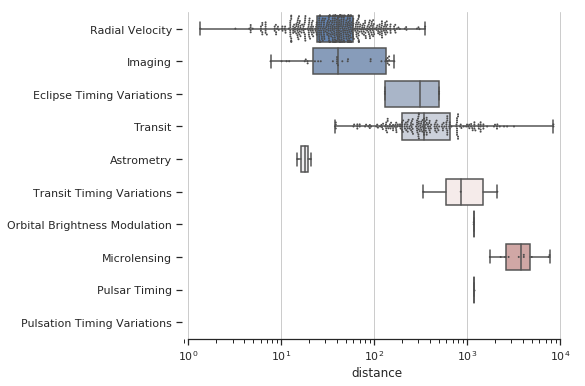

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Load the example planets dataset
planets = sns.load_dataset("planets")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="distance", y="method", data=planets,
            whis=[0, 100], palette="vlag")

# Add in points to show each observation
sns.swarmplot(x="distance", y="method", data=planets,
              size=2, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

                       342       352
prep              0.514023  0.014023
layer1_conv0_3_3  0.008848  0.058848
layer1_conv1_3_3  0.043743  0.543743
layer1_conv2_3_3  0.060375  0.010375
layer2_conv0_3_3  0.078117  0.077812
layer3_conv0_3_3  0.003509  0.635091
layer3_conv1_3_3  0.529869  0.002987
layer3_conv2_5_5  0.006105  0.000105
rest              0.500276  0.000276


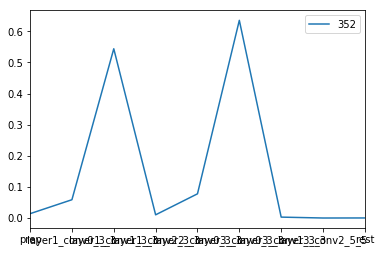

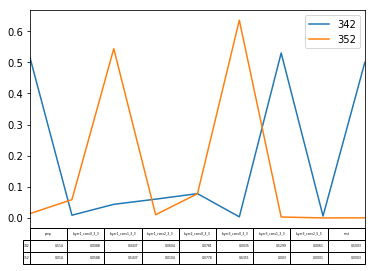

In [44]:
import pandas as pd
import numpy as np
# data = {'row_1': [3, 2, 1, 0], 'row_2': ['a', 'b', 'c', 'd']}
df=[] 
df=pd.DataFrame(df)
# print(df)

data_ = {"parameter_id": 342, "parameter_source": "algorithm", "parameters": {"prep": 0.514023277677920639, "layer1_conv0_3_3": 0.008847906663961557, "layer1_conv1_3_3": 0.0437431224737393, "layer1_conv2_3_3": 0.06037545930205553, "layer2_conv0_3_3": 0.07811710541161336, "layer3_conv0_3_3": 0.0035091064328109252, "layer3_conv1_3_3": 0.529869155313514855, "layer3_conv2_5_5": 0.00610455474345945633, "rest": 0.5002757880995515148}, "parameter_index": 0}
data = data_["parameters"]
# print(type(str(data_["parameter_id"])))
a = pd.DataFrame.from_dict(data, orient='index', columns=[str(data_["parameter_id"])])
c = pd.concat([df,a], axis=1)
# print(c)
 
data_ = {"parameter_id": 352, "parameter_source": "algorithm", "parameters": {"prep": 0.014023277677920639, "layer1_conv0_3_3": 0.058847906663961557, "layer1_conv1_3_3": 0.5437431224737393, "layer1_conv2_3_3": 0.01037545930205553, "layer2_conv0_3_3": 0.077811710541161336, "layer3_conv0_3_3": 0.635091064328109252, "layer3_conv1_3_3": 0.0029869155313514855, "layer3_conv2_5_5": 0.00010455474345945633, "rest": 0.0002757880995515148}, "parameter_index": 0}
data = data_["parameters"]
b = pd.DataFrame.from_dict(data, orient='index', columns=[str(data_["parameter_id"])])
d = pd.concat([a,b], axis=1)
print(d)
    
# df3 = pd.DataFrame(np.random.randn(1000, 2), columns=['B', 'C']).cumsum()
# print(df3)
# df3['A'] = pd.Series(list(range(len(df3))))
# df3.plot(x='A', y='B')

# 比较一列不同conv的lr
# d['trials'] = list(range(len(d)))
# d.plot(x='trials', y='352')
d.plot(y='352')


# fig, ax = plt.subplots(1, 1)
# df = pd.DataFrame(np.random.rand(5, 3), columns=['a', 'b', 'c'])
# ax.get_xaxis().set_visible(False)   # Hide Ticks
# df.plot(table=np.round(df.T, 2), ax=ax)

# 比较多列不同conv的lr
# plt.figure(figsize=(36, 24))
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
d.plot(table=np.round(d.T, 4), ax=ax)
plt.savefig("filename.png", dpi=200, bbox_inches=None )# = 'tight'

# 根据metric的范围，每一个conv的·learning rate分布


         prep  layer1_conv0_3_3  layer1_conv1_3_3  layer1_conv2_3_3  \
342  0.514023          0.008848          0.043743          0.060375   
352  0.014023          0.058848          0.543743          0.010375   

     layer2_conv0_3_3  layer3_conv0_3_3  layer3_conv1_3_3  layer3_conv2_5_5  \
342          0.078117          0.003509          0.529869          0.006105   
352          0.077812          0.635091          0.002987          0.000105   

         rest  metrics  
342  0.500276     71.0  
352  0.000276     72.0  


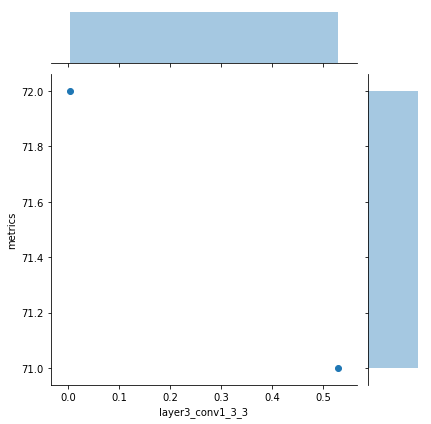

In [2]:
import os, glob, re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# data = {'row_1': [3, 2, 1, 0], 'row_2': ['a', 'b', 'c', 'd']}
df=[] 
df=pd.DataFrame(df)
# print(df)

data_ = {"parameter_id": 342, "parameter_source": "algorithm", "parameters": {"prep": 0.514023277677920639, "layer1_conv0_3_3": 0.008847906663961557, "layer1_conv1_3_3": 0.0437431224737393, "layer1_conv2_3_3": 0.06037545930205553, "layer2_conv0_3_3": 0.07811710541161336, "layer3_conv0_3_3": 0.0035091064328109252, "layer3_conv1_3_3": 0.529869155313514855, "layer3_conv2_5_5": 0.00610455474345945633, "rest": 0.5002757880995515148}, "parameter_index": 0}
data = data_["parameters"]
# print(type(str(data_["parameter_id"])))
a = pd.DataFrame.from_dict(data, orient='index', columns=[str(data_["parameter_id"])])
a.loc['metrics'] = float(71) 
c = pd.concat([df,a], axis=1)
# print(c)
 
data_ = {"parameter_id": 352, "parameter_source": "algorithm", "parameters": {"prep": 0.014023277677920639, "layer1_conv0_3_3": 0.058847906663961557, "layer1_conv1_3_3": 0.5437431224737393, "layer1_conv2_3_3": 0.01037545930205553, "layer2_conv0_3_3": 0.077811710541161336, "layer3_conv0_3_3": 0.635091064328109252, "layer3_conv1_3_3": 0.0029869155313514855, "layer3_conv2_5_5": 0.00010455474345945633, "rest": 0.0002757880995515148}, "parameter_index": 0}
data = data_["parameters"]
b = pd.DataFrame.from_dict(data, orient='index', columns=[str(data_["parameter_id"])])
b.loc['metrics'] = float(72) 
d = pd.concat([a,b], axis=1)
## print(d)
    
# df3 = pd.DataFrame(np.random.randn(1000, 2), columns=['B', 'C']).cumsum()
# print(df3)
# df3['A'] = pd.Series(list(range(len(df3))))
# df3.plot(x='A', y='B')

# 比较一列不同conv的lr
# d['trials'] = list(range(len(d)))
# d.plot(x='trials', y='352')

## d.plot(y='352')


# fig, ax = plt.subplots(1, 1)
# df = pd.DataFrame(np.random.rand(5, 3), columns=['a', 'b', 'c'])
# ax.get_xaxis().set_visible(False)   # Hide Ticks
# df.plot(table=np.round(df.T, 2), ax=ax)

# 比较多列不同conv的lr
# plt.figure(figsize=(36, 24))

## fig, ax = plt.subplots(1, 1)
## ax.get_xaxis().set_visible(False)
## d.plot(table=np.round(d.T, 4), ax=ax)

# plt.savefig("filename.png", dpi=200, bbox_inches=None )# = 'tight'

# 根据metric的范围，每一个conv的·learning rate分布

d = pd.DataFrame(d.values.T, index=d.columns, columns=d.index)
print(d)

#d['layer3_conv1_3_3'].astype(np.int64) 
#d['metrics'].astype(np.float64) 
# sns.jointplot(x=tb_layer3_conv1_3_3_r.index, y="layer3_conv1_3_3", data=tb_layer3_conv1_3_3_r, kind='scatter')
# d.plot.scatter(x=d['layer3_conv1_3_3'], y=d['metrics'], data=d)
sns.jointplot(x=d['layer3_conv1_3_3'], y=d['metrics'], data=d, kind='scatter')

In [1]:
import matplotlib
matplotlib.get_backend()

'module://ipykernel.pylab.backend_inline'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#导数数据集'titanic'
titanic=sns.load_dataset('titanic')
#查看数据集的随机10行数据，用sample方法
titanic.sample(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
604,1,1,male,35.0,0,0,26.5500,C,First,man,True,NaN,Cherbourg,yes,True
879,1,1,female,56.0,0,1,83.1583,C,First,woman,False,C,Cherbourg,yes,False
247,1,2,female,24.0,0,2,14.5000,S,Second,woman,False,NaN,Southampton,yes,False
234,0,2,male,24.0,0,0,10.5000,S,Second,man,True,NaN,Southampton,no,True
760,0,3,male,NaN,0,0,14.5000,S,Third,man,True,NaN,Southampton,no,True


/home/ubuntu/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ubuntu/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


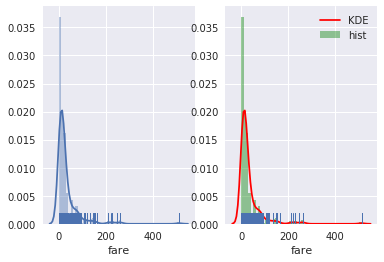

In [41]:
#去除'age'中的缺失值，distplot不能处理缺失数据
# age1=titanic['age'].dropna()
age1=titanic['fare'].dropna()

#  distplot() 默认拟合出了 密度曲线 Whether to plot a gaussian kernel density estimate.
# sns.distplot(age1)
# sns.distplot(age1,kde=False)
# 通过'bins'参数设定数据片段的数量 20
# sns.distplot(age1,bins=20,kde=False)

#创建一个一行2列的画布,主要方便对比
# fig,axes=plt.subplots(1,2)
#设置'reg'参数，加上观测数值的边际毛毯
#需要用axes[]表示是第几张图，从0开始
# sns.distplot(age1,bins=20,ax=axes[0]) #左图
# sns.distplot(age1,bins=20,rug=True,ax=axes[1]) #右图


#可以分别控制直方图、密度图的关键参数
fig,axes=plt.subplots(1,2) 
sns.distplot(age1,rug=True,ax=axes[0])
sns.distplot(age1,rug=True,
                     hist_kws={'color':'green','label':'hist'},
                     kde_kws={'color':'red','label':'KDE'},
                     ax=axes[1])

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#导入数据集'iris'
iris=sns.load_dataset('iris')

#随机查看数据集的10行数据
iris.sample(10)

,sepal_length,sepal_width,petal_length,petal_width,species
138,6.0,3.0,4.8,1.8,virginica
101,5.8,2.7,5.1,1.9,virginica
114,5.8,2.8,5.1,2.4,virginica
58,6.6,2.9,4.6,1.3,versicolor
31,5.4,3.4,1.5,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
87,6.3,2.3,4.4,1.3,versicolor
35,5.0,3.2,1.2,0.2,setosa
54,6.5,2.8,4.6,1.5,versicolor
25,5.0,3.0,1.6,0.2,setosa


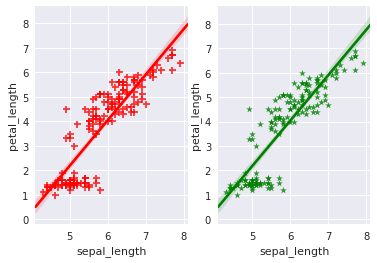

In [43]:
fig,axes=plt.subplots(1,2) 

sns.regplot(x='sepal_length',y='petal_length',data=iris,
            color='r',marker='+',ax=axes[0])

sns.regplot(x='sepal_length',y='petal_length',data=iris,
            color='g',marker='*',ax=axes[1])

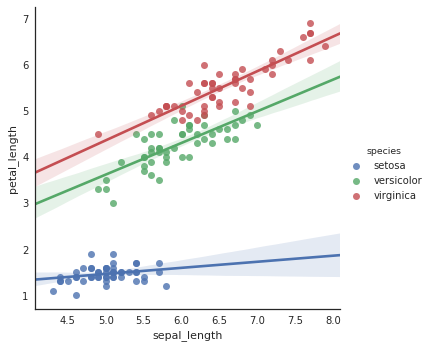

In [51]:

sns.lmplot(x='sepal_length',y='petal_length', hue='species',data=iris)

# sns.lmplot(x='sepal_length',y='petal_length',hue='species', data=iris,markers=['*','o','+'],fit_reg=False)

# sns.lmplot(x='sepal_length',y='petal_length',hue='species', data=iris,markers=['*','o','+'])

# sns.lmplot(x='sepal_length',y='petal_length', col='species',data=iris)

/home/ubuntu/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


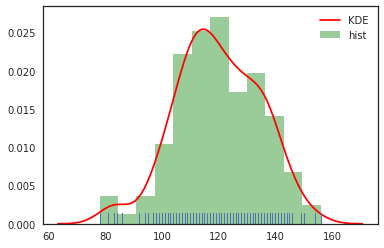

In [53]:
a = [131, 98, 125, 131, 124, 139, 131, 117, 128, 108, 135, 138, 131, 102, 107, 114, 119, 128, 121, 142, 127, 130, 124,
     101, 110, 116, 117, 110, 128, 128, 115, 99, 136, 126, 134, 95, 138, 117, 111, 78, 132, 124, 113, 150, 110, 117, 86,
     95, 144, 105, 126, 130, 126, 130, 126, 116, 123, 106, 112, 138, 123, 86, 101, 99, 136, 123, 117, 119, 105, 137,
     123, 128, 125, 104, 109, 134, 125, 127, 105, 120, 107, 129, 116, 108, 132, 103, 136, 118, 102, 120, 114, 105, 115,
     132, 145, 119, 121, 112, 139, 125, 138, 109, 132, 134, 156, 106, 117, 127, 144, 139, 139, 119, 140, 83, 110, 102,
     123, 107, 143, 115, 136, 118, 139, 123, 112, 118, 125, 109, 119, 133, 112, 114, 122, 109, 106, 123, 116, 131, 127,
     115, 118, 112, 135, 115, 146, 137, 116, 103, 144, 83, 123, 111, 110, 111, 100, 154, 136, 100, 118, 119, 133, 134,
     106, 129, 126, 110, 111, 109, 141, 120, 117, 106, 149, 122, 122, 110, 118, 127, 121, 114, 125, 126, 114, 140, 103,
     130, 141, 117, 106, 114, 121, 114, 133, 137, 92, 121, 112, 146, 97, 137, 105, 98, 117, 112, 81, 97, 139, 113, 134,
     106, 144, 110, 137, 137, 111, 104, 117, 100, 111, 101, 110, 105, 129, 137, 112, 120, 113, 133, 112, 83, 94, 146,
     133, 101, 131, 116, 111, 84, 137, 115, 122, 106, 144, 109, 123, 116, 111, 111, 133, 150]

# sns.distplot(a,bins=20,kde=False)
sns.distplot(a,rug=True,
                     hist_kws={'color':'green','label':'hist'},
                     kde_kws={'color':'red','label':'KDE'})

/home/ubuntu/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


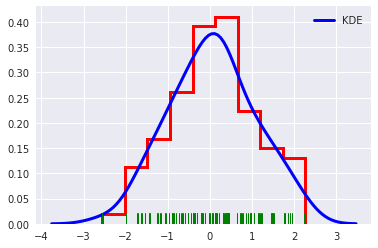

In [48]:
import seaborn as sns, numpy as np
sns.set(); np.random.seed(0)
x = np.random.randn(100)
# ax = sns.distplot(x)
ax = sns.distplot(x, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "b", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "r"})

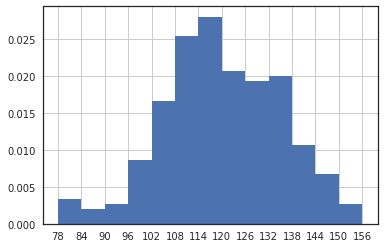

In [11]:
from matplotlib import pyplot as plt
from matplotlib import font_manager

a = [131, 98, 125, 131, 124, 139, 131, 117, 128, 108, 135, 138, 131, 102, 107, 114, 119, 128, 121, 142, 127, 130, 124,
     101, 110, 116, 117, 110, 128, 128, 115, 99, 136, 126, 134, 95, 138, 117, 111, 78, 132, 124, 113, 150, 110, 117, 86,
     95, 144, 105, 126, 130, 126, 130, 126, 116, 123, 106, 112, 138, 123, 86, 101, 99, 136, 123, 117, 119, 105, 137,
     123, 128, 125, 104, 109, 134, 125, 127, 105, 120, 107, 129, 116, 108, 132, 103, 136, 118, 102, 120, 114, 105, 115,
     132, 145, 119, 121, 112, 139, 125, 138, 109, 132, 134, 156, 106, 117, 127, 144, 139, 139, 119, 140, 83, 110, 102,
     123, 107, 143, 115, 136, 118, 139, 123, 112, 118, 125, 109, 119, 133, 112, 114, 122, 109, 106, 123, 116, 131, 127,
     115, 118, 112, 135, 115, 146, 137, 116, 103, 144, 83, 123, 111, 110, 111, 100, 154, 136, 100, 118, 119, 133, 134,
     106, 129, 126, 110, 111, 109, 141, 120, 117, 106, 149, 122, 122, 110, 118, 127, 121, 114, 125, 126, 114, 140, 103,
     130, 141, 117, 106, 114, 121, 114, 133, 137, 92, 121, 112, 146, 97, 137, 105, 98, 117, 112, 81, 97, 139, 113, 134,
     106, 144, 110, 137, 137, 111, 104, 117, 100, 111, 101, 110, 105, 129, 137, 112, 120, 113, 133, 112, 83, 94, 146,
     133, 101, 131, 116, 111, 84, 137, 115, 122, 106, 144, 109, 123, 116, 111, 111, 133, 150]
# 数据如果在100以内分为5-12组
# 组距:指的是每个小组两个端点的距离
# 组数:极差/组距
# 计算组数
d = 6  # 组距
num_bins = (max(a) - min(a)) // d
# a为传入的数据 其中数据应该都是数字类型的 num_bins为需要将数据分为多少组
# density为1或者为True时 可以改变为频率分布直方图
plt.hist(a, num_bins,density=1)
plt.xticks(range(min(a), max(a) + d, d))
# 设置网格
plt.grid()
# plt.savefig("./05.png")
plt.show()


Text(0.5, 1.0, "Athlete's height")

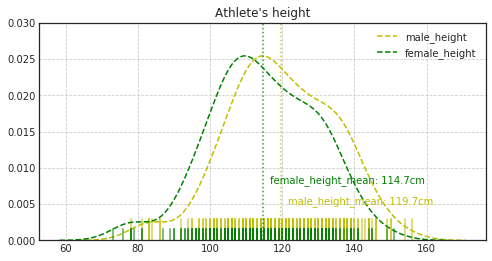

In [22]:
from matplotlib import pyplot as plt
sns.set_style('white')
# 图表风格设置
# 风格选择包括："white", "dark", "whitegrid", "darkgrid", "ticks"

def Get_Average(list):
   sum = 0
   for item in list:     
      sum += item  
   return sum/len(list)

""""""
data_male_ = [131, 98, 125, 131, 124, 139, 131, 117, 128, 108, 135, 138, 131, 102, 107, 114, 119, 128, 121, 142, 127, 130, 124,
     101, 110, 116, 117, 110, 128, 128, 115, 99, 136, 126, 134, 95, 138, 117, 111, 78, 132, 124, 113, 150, 110, 117, 86,
     95, 144, 105, 126, 130, 126, 130, 126, 116, 123, 106, 112, 138, 123, 86, 101, 99, 136, 123, 117, 119, 105, 137,
     123, 128, 125, 104, 109, 134, 125, 127, 105, 120, 107, 129, 116, 108, 132, 103, 136, 118, 102, 120, 114, 105, 115,
     132, 145, 119, 121, 112, 139, 125, 138, 109, 132, 134, 156, 106, 117, 127, 144, 139, 139, 119, 140, 83, 110, 102,
     123, 107, 143, 115, 136, 118, 139, 123, 112, 118, 125, 109, 119, 133, 112, 114, 122, 109, 106, 123, 116, 131, 127,
     115, 118, 112, 135, 115, 146, 137, 116, 103, 144, 83, 123, 111, 110, 111, 100, 154, 136, 100, 118, 119, 133, 134,
     106, 129, 126, 110, 111, 109, 141, 120, 117, 106, 149, 122, 122, 110, 118, 127, 121, 114, 125, 126, 114, 140, 103,
     130, 141, 117, 106, 114, 121, 114, 133, 137, 92, 121, 112, 146, 97, 137, 105, 98, 117, 112, 81, 97, 139, 113, 134,
     106, 144, 110, 137, 137, 111, 104, 117, 100, 111, 101, 110, 105, 129, 137, 112, 120, 113, 133, 112, 83, 94, 146,
     133, 101, 131, 116, 111, 84, 137, 115, 122, 106, 144, 109, 123, 116, 111, 111, 133, 150]

hmean_male = Get_Average(data_male_) 

data_female_ = [i-5 for i in data_male_]
hmean_female = Get_Average(data_female_) 

data_female = {'height': data_female_}

data_male = {'height': [131, 98, 125, 131, 124, 139, 131, 117, 128, 108, 135, 138, 131, 102, 107, 114, 119, 128, 121, 142, 127, 130, 124,
     101, 110, 116, 117, 110, 128, 128, 115, 99, 136, 126, 134, 95, 138, 117, 111, 78, 132, 124, 113, 150, 110, 117, 86,
     95, 144, 105, 126, 130, 126, 130, 126, 116, 123, 106, 112, 138, 123, 86, 101, 99, 136, 123, 117, 119, 105, 137,
     123, 128, 125, 104, 109, 134, 125, 127, 105, 120, 107, 129, 116, 108, 132, 103, 136, 118, 102, 120, 114, 105, 115,
     132, 145, 119, 121, 112, 139, 125, 138, 109, 132, 134, 156, 106, 117, 127, 144, 139, 139, 119, 140, 83, 110, 102,
     123, 107, 143, 115, 136, 118, 139, 123, 112, 118, 125, 109, 119, 133, 112, 114, 122, 109, 106, 123, 116, 131, 127,
     115, 118, 112, 135, 115, 146, 137, 116, 103, 144, 83, 123, 111, 110, 111, 100, 154, 136, 100, 118, 119, 133, 134,
     106, 129, 126, 110, 111, 109, 141, 120, 117, 106, 149, 122, 122, 110, 118, 127, 121, 114, 125, 126, 114, 140, 103,
     130, 141, 117, 106, 114, 121, 114, 133, 137, 92, 121, 112, 146, 97, 137, 105, 98, 117, 112, 81, 97, 139, 113, 134,
     106, 144, 110, 137, 137, 111, 104, 117, 100, 111, 101, 110, 105, 129, 137, 112, 120, 113, 133, 112, 83, 94, 146,
     133, 101, 131, 116, 111, 84, 137, 115, 122, 106, 144, 109, 123, 116, 111, 111, 133, 150]
}

plt.figure(figsize=(8,4))#绘制画布
sns.distplot(data_male['height'],hist = False,kde = True,rug = True,
             rug_kws = {'color':'y','lw':2,'alpha':0.5,'height':0.1} ,   # 设置数据频率分布颜色#控制是否显示观测的小细条（边际毛毯）
             kde_kws={"color": "y", "lw": 1.5, 'linestyle':'--'},        # 设置密度曲线颜色，线宽，标注、线形，#控制是否显示核密度估计图
             label = 'male_height')


sns.distplot(data_female['height'],hist = False,bins=6,kde = True,rug = True,
             rug_kws = {'color':'g','lw':2,'alpha':0.5} , 
             kde_kws={"color": "g", "lw": 1.5, 'linestyle':'--'},
             label = 'female_height')



# 绘制男女高度分布密度图
plt.axvline(hmean_male,color='y',linestyle=":",alpha=0.8) 
plt.text(hmean_male+2,0.005,'male_height_mean: %.1fcm' % (hmean_male), color = 'y')
# 绘制男运动员平均身高辅助线

plt.axvline(hmean_female,color='g',linestyle=":",alpha=0.8)
plt.text(hmean_female+2,0.008,'female_height_mean: %.1fcm' % (hmean_female), color = 'g')
# 绘制女运动员平均身高辅助线

plt.ylim([0,0.03])
plt.grid(linestyle = '--')     # 添加网格线
plt.title("Athlete's height")  # 添加图表名


/home/ubuntu/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


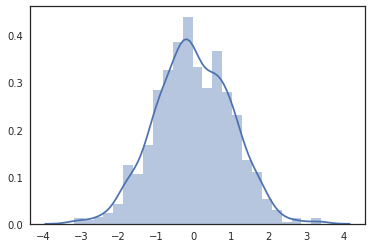

In [7]:
np.random.seed(666)
x = np.random.randn(1000)
ax = sns.distplot(x)

/home/ubuntu/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


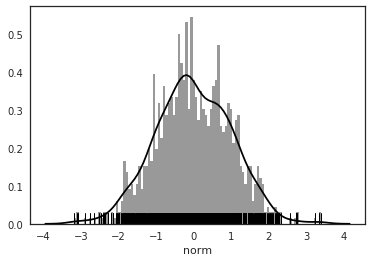

In [9]:
np.random.seed(666)
x = np.random.randn(1000)
ax = sns.distplot(x, bins=100,hist=True, kde=True, rug=True,color='k',axlabel='norm')

/home/ubuntu/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Normal Distribution')]

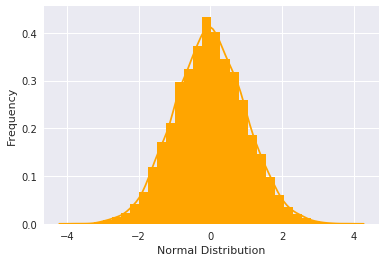

In [4]:
from scipy.stats import norm
data_norm = norm.rvs(size = 10000, loc = 0, scale = 1)
ax = sns.distplot(data_norm, bins = 30, kde = True, color = 'orange', hist_kws = {'linewidth': 1, 'alpha': 1})
ax.set(xlabel = 'Normal Distribution', ylabel = 'Frequency')

/home/ubuntu/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Exponential Distribution')]

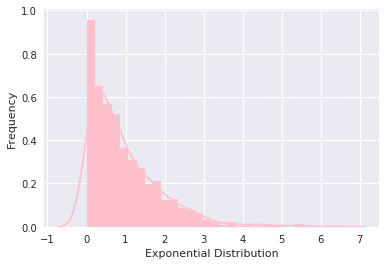

In [5]:
from scipy.stats import expon
data_expon = expon.rvs(scale = 1, loc = 0, size = 1000)
ax = sns.distplot(data_expon, kde = True, bins = 30, color = 'pink', hist_kws = {'linewidth': 1, 'alpha':1})
ax.set(xlabel = 'Exponential Distribution', ylabel = 'Frequency')

### Set GPU clocks

In [1]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

Applications clocks set to "(MEM 877, SM 1530)" for GPU 00000000:00:1E.0
All done.


In [3]:
from core import *
from torch_backend import *

### Network definition

In [4]:
def conv_bn(c_in, c_out):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
        'bn': BatchNorm(c_out), 
        'relu': nn.ReLU(True)
    }

def residual(c):
    return {
        'in': Identity(),
        'res1': conv_bn(c, c),
        'res2': conv_bn(c, c),
        'add': (Add(), ['in', 'res2/relu']),
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3')):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    n = {
        'input': (None, []),
        'prep': conv_bn(3, channels['prep']),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1']), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2']), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3']), pool=pool),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'logits': Mul(weight),
    }
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer])
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer])       
    return n

### Download and preprocess data

In [5]:
DATA_DIR = './data'
dataset = cifar10(root=DATA_DIR)
timer = Timer()
print('Preprocessing training data')
transforms = [
    partial(normalise, mean=np.array(cifar10_mean, dtype=np.float32), std=np.array(cifar10_std, dtype=np.float32)),
    partial(transpose, source='NHWC', target='NCHW'), 
]
train_set = list(zip(*preprocess(dataset['train'], [partial(pad, border=4)] + transforms).values()))
print(f'Finished in {timer():.2} seconds')
print('Preprocessing test data')
valid_set = list(zip(*preprocess(dataset['valid'], transforms).values()))
print(f'Finished in {timer():.2} seconds')

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:02, 70547822.20it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Preprocessing training data
Finished in 2.0 seconds
Preprocessing test data
Finished in 0.084 seconds


### Network visualisation

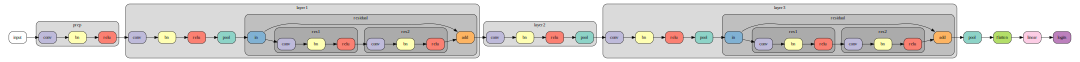

In [6]:
colors = ColorMap()
draw = lambda graph: DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None})

draw(build_graph(net()))

### Training

NB: on the first run, the first epoch will be slower as initialisation and Cudnn benchmarking take place.

In [7]:
epochs=24
lr_schedule = PiecewiseLinear([0, 5, epochs], [0, 0.4, 0])
batch_size = 512
train_transforms = [Crop(32, 32), FlipLR(), Cutout(8, 8)]
N_runs = 3

train_batches = DataLoader(Transform(train_set, train_transforms), batch_size, shuffle=True, set_random_choices=True, drop_last=True)
valid_batches = DataLoader(valid_set, batch_size, shuffle=False, drop_last=False)
lr = lambda step: lr_schedule(step/len(train_batches))/batch_size

summaries = []
for i in range(N_runs):
    print(f'Starting Run {i} at {localtime()}')
    model = Network(net()).to(device).half()
    opts = [SGD(trainable_params(model).values(), {'lr': lr, 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)})]
    logs, state = Table(), {MODEL: model, LOSS: x_ent_loss, OPTS: opts}
    for epoch in range(epochs):
        logs.append(union({'epoch': epoch+1}, train_epoch(state, Timer(torch.cuda.synchronize), train_batches, valid_batches)))
logs.df().query(f'epoch=={epochs}')[['train_acc', 'valid_acc']].describe()

Starting Run 0 at 2020-04-13 06:48:53
       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       5.1745       1.6422       0.4097       0.4200       1.1348       0.5865       5.1745
           2       3.0237       0.9376       0.6672       0.2144       1.2506       0.6042       3.0237
           3       3.0360       0.7366       0.7410       0.2125       0.7540       0.7425       3.0360
           4       3.0127       0.6218       0.7841       0.2124       0.6465       0.7792       3.0127
           5       3.0119       0.5627       0.8043       0.2126       0.6434       0.7764       3.0119
           6       3.0122       0.4978       0.8274       0.2353       0.5550       0.8115       3.0122
           7       3.0112       0.4455       0.8460       0.2125       0.5736       0.7996       3.0112
           8       3.0113       0.4082       0.8610       0.2125       0.4214       0.8532       3.0113
           9       3.0156 

,train_acc,valid_acc
count,1.000000,1.0000
mean,0.979502,0.9429
std,NaN,NaN
min,0.979502,0.9429
25%,0.979502,0.9429
50%,0.979502,0.9429
75%,0.979502,0.9429
max,0.979502,0.9429


In [84]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
from datetime import datetime
from scipy import stats
from collections import defaultdict
import itertools
import sys

sns.set(context='poster', style='white', palette='deep', color_codes=True) #, font_scale=1.5)

# t_edges = np.linspace(0, t_max, num=1000)

m_edges = np.logspace(0, 10)

# data = defaultdict(list)
data = []
# for p_r in [0.00005, 0.0005, 0.005, 0.05]:
model = 1
min = 1.8
x_0 = 40
n = 5000
# n = '{:f}'.format(p_r).rstrip('0')

# flavor = 'extant_m{}_{}_{}_{}'.format(model, min, x_0, n)

# flavor = 'min_cope_ext'

# print('Grabbing the {} data.'.format(flavor))

# batch = 0
# # Read in the data
# while True:
# 	try:
# 		curr = pd.read_csv('/Users/Trevor/Desktop/figure data/Tutorial Data/{}_b{}.csv'.format(flavor, batch),
# 			header=None,
# 			names=['id', 'birth', 'mass', 'm_min', 'death', 'ancestor', 'niche'])
# 		# data[p_r].append(list(map(float, curr['mass'].values.tolist())))
# 		data.append(list(map(float, curr['mass'].values.tolist())))
# 		batch += 1
# 	except FileNotFoundError:
# 		print('Loaded {} files.'.format(batch))
# 		break
# 	except:
# 		print("Unexpected error:", sys.exc_info()[0])
# 		break



# data_b = []
# flavor = 'extant_m{}_{}_{}_{}'.format(model, min, x_0, n)

# print('Grabbing the {} data.'.format(flavor))

# batch = 0
# # Read in the data
# while True:
# 	try:
# 		# curr = pd.read_csv('/Users/Trevor/Desktop/figure data/unconstrainedNicheRuns/{}_b{}.csv'.format(flavor, batch),
# 		curr = pd.read_csv('{}_b{}.csv'.format(flavor, batch),
# 			header=None,
# 			names=['id', 'birth', 'mass', 'm_min', 'death', 'ancestor', 'niche'])
# 		# data[p_r].append(list(map(float, curr['mass'].values.tolist())))
# 		data_b.append(list(map(float, curr['mass'].values.tolist())))
# 		batch += 1
# 	except FileNotFoundError:
# 		print('Loaded {} files.'.format(batch))
# 		break
# 	except:
# 		print("Unexpected error:", sys.exc_info()[0])
# 		break

# biggest = 0
# for ed in data_b:
# 	for e in ed:
# 		if e > biggest:
# 			biggest = e

# print('Biggest m_min: {}'.format(biggest))

########## For getting aggregate results from MOMsim
data_t = []
data_a = []

model = 1
min = 1.8
x_0 = 40
n = 5000

# flavor = '/Users/Trevor/Desktop/figure data/MOMsim/run 3/extant_m{}_{}_{}_{}'.format(model, min, x_0, n)
flavor = 'extant_m{}_{}_{}_{}no'.format(model, min, x_0, n)

# Read in the data
batch = 0
while True:
	try:
		# 'C:/Users/Trevor/Desktop/Tutorial Data/{}_b{}.csv'
		curr = pd.read_csv('{}_b{}.csv'.format(flavor, batch),
			header=None,
			names=['id', 'birth', 'mass', 'm_min', 'death', 'ancestor', 'niche'])
		t = curr[curr['niche'] == 0]['mass'] # terrestrial
		a = curr[curr['niche'] == 1]['mass'] # aquatic
		data_t.append(list(map(float, t.values.tolist())))
		data_a.append(list(map(float, a.values.tolist())))
		batch += 1
	except FileNotFoundError:
		print('Loaded {} files.'.format(batch))
		break
	except:
		print("Unexpected error:", sys.exc_info()[0])
		break



def plot_MOM( ):
	fig = sns.plt.figure(figsize=(9, 4.75), dpi=80)
	ax = fig.add_subplot(111)

	mom = pd.read_csv('MOM_data_full.txt', sep=', ', engine='python')

	x_t = mom[mom['land'] == 1]['mass']
	x_a = mom[mom['land'] == 0]['mass']
	x_mom = mom['mass']

	n_mom = len(x_t) + len(x_a)
	m_t_dist = np.histogram(x_t, bins=m_edges, density=True)[0]
	m_a_dist = np.histogram(x_a, bins=m_edges, density=True)[0]
	m_mom_dist = np.histogram(x_mom, bins=m_edges, density=True)[0]

	p_t = ax.scatter(m_edges[:-1], m_t_dist, marker='x', s=42, color='g')
	p_a = ax.scatter(m_edges[:-1], m_a_dist, marker='o', s=42, color='b')
	p_mom = ax.scatter(m_edges[:-1], m_mom_dist, marker='+', s=30, color='r')

	ax.legend([p_t, p_a, p_mom], ['terrestrial', 'aquatic', 'all mammals'])

	sns.plt.xscale('log')
	sns.plt.yscale('log')
	sns.plt.ylim(0.000000000001, sns.plt.ylim()[1])
	sns.plt.xlabel('species mass, g')
	sns.plt.ylabel('frequency (log scale), arb.')
	sns.plt.yticks([])
	sns.plt.tight_layout()
	sns.despine()


def plot_clade_largest( data ):
	big_start = datetime.now()
	print('Starting to plot largest extant masses.')

	largest = []
	for extant_dist in data:
		# print(np.histogram(extant_dist, bins=m_edges)[0])
		largest.append(np.amax(extant_dist))

	fig = sns.plt.figure(figsize=(9, 4.75), dpi=80)
	ax = fig.add_subplot(111)

	ax.scatter(range(len(largest)), largest, s=42, marker='x')

	sns.plt.xlabel('model time')
	sns.plt.xticks([])
	sns.plt.yscale('log')
	sns.plt.ylabel('largest mass seen, g')
	sns.plt.tight_layout()
	sns.despine()

	print('All species took {} seconds.'.format((datetime.now() - big_start).total_seconds()))


def plot_extant_dist( data, ax, leg='simulation' ):
	big_start = datetime.now()
	print('Starting to plot extant mass distribution.')

	dists = []
	for extant_dist in data:
		# print(np.histogram(extant_dist, bins=m_edges)[0])
		dists.append(np.histogram(extant_dist, bins=m_edges)[0] / len(extant_dist))

	dists = np.array(dists)

	# Take the mean (and quartiles) between the histogram counts
	m_dist = np.mean(dists, axis=0)

	# Grab 95% confidence intervals
	sigma = np.std(dists, axis=0)
	# ci_low = [stats.norm.interval(0.95, loc=m, scale=s)[0] for (m, s) in list(zip(m_dist, sigma))]
	# ci_high = [stats.norm.interval(0.95, loc=m, scale=s)[1] for (m, s) in list(zip(m_dist, sigma))]

	mom = pd.read_csv('MOM_data_full.txt', sep=', ', engine='python')
	x_t = mom[mom['land'] == 1]['mass']
	x_a = mom[mom['land'] == 0]['mass']
	# x_mom = mom['mass']
	n_mom = len(x_t) + len(x_a)
	m_t_dist = np.histogram(x_t, bins=m_edges)[0] / n_mom
	m_a_dist = np.histogram(x_a, bins=m_edges)[0] / n_mom
	# m_mom_dist = np.histogram(x_mom, bins=m_edges)[0]
	p_t = ax.scatter(m_edges[:-1], m_t_dist, marker='x', s=30, color='g')
	p_a = ax.scatter(m_edges[:-1], m_a_dist, marker='o', s=30, color='b')
	# p_mom = ax.scatter(m_edges[:-1], m_mom_dist, marker='x', s=30, color='r')

	# p_m = ax.scatter(m_edges[:-1], m_dist, marker='D', s=42, color='k')

	ax.legend([p_t, p_a], ['terrestrial', 'aquatic', leg])

	# ax.plot(m_edges[1:-1], ci_low[1:], linewidth=0.75, ls='--', color='k')
	# ax.plot(m_edges[1:-1], ci_high[1:], linewidth=0.75, ls='--', color='k')
	

	sns.plt.xscale('log')
	sns.plt.yscale('log')
	# (1.0 / 5000.0)
	# 0.000000000001
	# 0.9
	sns.plt.ylim((1.0 / 5000.0), sns.plt.ylim()[1])
	sns.plt.xlabel('species mass, g')
	sns.plt.ylabel('frequency (log scale), arb.')
	sns.plt.yticks([])
	sns.plt.tight_layout()
	sns.despine()

	print('All species took {} seconds.'.format((datetime.now() - big_start).total_seconds()))


def plot_extant_dist_density( data, ax, leg='simulation' ):
	big_start = datetime.now()
	print('Starting to plot extant mass distribution.')

	dists = []
	for extant_dist in data:
		# print(np.histogram(extant_dist, bins=m_edges)[0])
		dists.append(np.histogram(extant_dist, bins=m_edges, density=True)[0])

	dists = np.array(dists)

	# Take the mean (and quartiles) between the histogram counts
	m_dist = np.mean(dists, axis=0)

	# Grab 95% confidence intervals
	sigma = np.std(dists, axis=0)
	ci_low = [stats.norm.interval(0.95, loc=m, scale=s)[0] for (m, s) in list(zip(m_dist, sigma))]
	ci_high = [stats.norm.interval(0.95, loc=m, scale=s)[1] for (m, s) in list(zip(m_dist, sigma))]

	mom = pd.read_csv('MOM_data_full.txt', sep=', ', engine='python')
	x_t = mom[mom['land'] == 1]['mass']
	# x_a = mom[mom['land'] == 0]['mass']
	# x_mom = mom['mass']
	# n_mom = len(x_t) + len(x_a)
	m_t_dist = np.histogram(x_t, bins=m_edges, density=True)[0]
	# m_a_dist = np.histogram(x_a, bins=m_edges, density=True)[0]
	# m_mom_dist = np.histogram(x_mom, bins=m_edges)[0]
	p_t = ax.scatter(m_edges[:-1], m_t_dist, marker='x', s=30, color='g')
	# p_a = ax.scatter(m_edges[:-1], m_a_dist, marker='o', s=30, color='b')
	# p_mom = ax.scatter(m_edges[:-1], m_mom_dist, marker='x', s=30, color='r')

	p_m = ax.scatter(m_edges[:-1], m_dist, marker='D', s=42, color='k')

	ax.legend([p_t, p_m], ['MOM terrestrial', leg])

	ax.plot(m_edges[1:-1], ci_low[1:], linewidth=0.75, ls='--', color='k')
	ax.plot(m_edges[1:-1], ci_high[1:], linewidth=0.75, ls='--', color='k')
	

	sns.plt.xscale('log')
	sns.plt.yscale('log')
	# (1.0 / 5000.0)
	# 0.000000000001
	# 0.9
	sns.plt.ylim(0.000000000001, sns.plt.ylim()[1])
	sns.plt.xlabel('species mass, g')
	sns.plt.ylabel('density (log scale), arb.')
	sns.plt.yticks([])
	sns.plt.tight_layout()
	sns.despine()

	print('All species took {} seconds.'.format((datetime.now() - big_start).total_seconds()))


def plot_extant_dist_MOMsim( data_t, data_a, ax, leg='simulation' ):
	big_start = datetime.now()
	print('Starting to plot extant mass distribution.')

	dists_t = []
	dists_a = []
	for (ed_t, ed_a) in list(zip(data_t, data_a)):
		# print(np.histogram(ed_t, bins=m_edges)[0])
		# print(np.histogram(ed_a, bins=m_edges)[0])
		n_tot = len(ed_a) + len(ed_t)
		# print(n_tot)
		dists_t.append(np.histogram(ed_t, bins=m_edges)[0] / n_tot)
		dists_a.append(np.histogram(ed_a, bins=m_edges)[0] / n_tot)
	
	dists_t = np.array(dists_t)
	dists_a = np.array(dists_a)

	# Take the mean (and quartiles) between the histogram counts
	m_dist_t = np.mean(dists_t, axis=0)
	m_dist_a = np.mean(dists_a, axis=0)

	# Grab 95% confidence intervals
	sigma_t = np.std(dists_t, axis=0)
	ci_low_t = [stats.norm.interval(0.95, loc=m, scale=s)[0] for (m, s) in list(zip(m_dist_t, sigma_t))]
	ci_high_t = [stats.norm.interval(0.95, loc=m, scale=s)[1] for (m, s) in list(zip(m_dist_t, sigma_t))]

	sigma_a = np.std(dists_a, axis=0)
	ci_low_a = [stats.norm.interval(0.95, loc=m, scale=s)[0] for (m, s) in list(zip(m_dist_a, sigma_a))]
	ci_high_a = [stats.norm.interval(0.95, loc=m, scale=s)[1] for (m, s) in list(zip(m_dist_a, sigma_a))]

	mom = pd.read_csv('MOM_data_full.txt', sep=', ', engine='python')
	x_t = mom[mom['land'] == 1]['mass']
	x_a = mom[mom['land'] == 0]['mass']
	# x_mom = mom['mass']
	n_mom = len(x_t) + len(x_a)
	m_t_dist = np.histogram(x_t, bins=m_edges)[0] / n_mom
	m_a_dist = np.histogram(x_a, bins=m_edges)[0] / n_mom
	# m_mom_dist = np.histogram(x_mom, bins=m_edges)[0]
	p_t = ax.scatter(m_edges[:-1], m_t_dist, marker='x', s=30, color='g')
	p_a = ax.scatter(m_edges[:-1], m_a_dist, marker='o', s=30, color='b')
	# p_mom = ax.scatter(m_edges[:-1], m_mom_dist, marker='x', s=30, color='r')

	p_m_t = ax.scatter(m_edges[:-1], m_dist_t, marker='D', s=42, color='k')
	p_m_a = ax.scatter(m_edges[:-1], m_dist_a, marker='D', s=42, color='k')

	ax.legend([p_t, p_a, p_m_t, p_m_a], ['MOM terrestrial', 'MOM aquatic', 'sim terrestrial', 'sim aquatic'])

	ax.plot(m_edges[1:-1], ci_low_t[1:], linewidth=0.75, ls='--', color='0.75')
	ax.plot(m_edges[1:-1], ci_high_t[1:], linewidth=0.75, ls='--', color='0.75')

	ax.plot(m_edges[1:-1], ci_low_a[1:], linewidth=0.75, ls='--', color='0.75')
	ax.plot(m_edges[1:-1], ci_high_a[1:], linewidth=0.75, ls='--', color='0.75')
	

	sns.plt.xscale('log')
	sns.plt.yscale('log')
	# (1.0 / 5000.0)
	# 0.000000000001
	# 0.9
	sns.plt.ylim((1.0 / 5000.0), sns.plt.ylim()[1])
	sns.plt.xlabel('species mass, g')
	sns.plt.ylabel('density (log scale), arb.')
	sns.plt.yticks([])
	sns.plt.tight_layout()
	sns.despine()

	print('All species took {} seconds.'.format((datetime.now() - big_start).total_seconds()))


def plot_extant_niche_dists( data ):
	big_start = datetime.now()
	print('Starting to plot extant mass distribution.')

	dists = []
	for row in list(zip(data['mass'], data['niche'])):
		d = pd.DataFrame(data=np.asarray(row).T.tolist(), columns=['mass', 'niche'])
		niches = d['niche'].unique()
		dists.append([np.histogram(d[d['niche'] == niche], bins=m_edges, density=True)[0] for niche in niches])

	dists = np.array(dists)

	# Take the mean (and quartiles) between the histogram counts
	m_dist = np.mean(dists, axis=0)
	print(m_dist)

	# Grab 95% confidence intervals
	sigma = np.std(dists, axis=0)
	ci_low = [stats.norm.interval(0.95, loc=m, scale=s)[0] for (m, s) in list(zip(m_dist, sigma))]
	ci_high = [stats.norm.interval(0.95, loc=m, scale=s)[1] for (m, s) in list(zip(m_dist, sigma))]


	fig = sns.plt.figure(figsize=(9, 4.75), dpi=80)
	ax = fig.add_subplot(111)

	mom = pd.read_csv('MOM_data_full.txt', sep=', ', engine='python')
	# x_t = mom[mom['land'] == 1]['mass']
	x_a = mom[mom['land'] == 0]['mass']
	# x_mom = mom['mass']
	# n_mom = len(x_t) + len(x_a)
	# m_t_dist = np.histogram(x_t, bins=m_edges, density=True)[0]
	m_a_dist = np.histogram(x_a, bins=m_edges, density=True)[0]
	# m_mom_dist = np.histogram(x_mom, bins=m_edges)[0]
	# p_t = ax.scatter(m_edges[:-1], m_t_dist, marker='x', s=30, color='g')
	p_a = ax.scatter(m_edges[:-1], m_a_dist, marker='o', s=30, color='b')
	# p_mom = ax.scatter(m_edges[:-1], m_mom_dist, marker='x', s=30, color='r')

	p_m = ax.scatter(m_edges[:-1], m_dist, marker='D', s=42, color='k')

	# ax.legend([p_t, p_m], ['MOM terrestrial', flavor])

	ax.plot(m_edges[1:-1], ci_low[1:], linewidth=0.75, ls='--', color='k')
	ax.plot(m_edges[1:-1], ci_high[1:], linewidth=0.75, ls='--', color='k')
	

	sns.plt.xscale('log')
	sns.plt.yscale('log')
	# (1.0 / 5000.0)
	# 0.000000000001
	# 0.9
	sns.plt.ylim(0.000000000001, sns.plt.ylim()[1])
	sns.plt.xlabel('species mass, g')
	sns.plt.ylabel('density (log scale), arb.')
	sns.plt.yticks([])
	sns.plt.gcf().subplots_adjust(bottom=0.15)
	sns.despine()

	print('All species took {} seconds.'.format((datetime.now() - big_start).total_seconds()))


def plot_lambda_dist( ):
	x = pd.read_csv('lambda_dist.csv', header=None, names=['x'])

	(dist, edges) = np.histogram(x, bins=42)

	fig = sns.plt.figure()
	ax = fig.add_subplot(111)

	ax.scatter(edges[:-1], dist)
	sns.plt.xlabel('lambda draw')
	sns.plt.ylabel('frequency')
	# sns.plt.gcf().subplots_adjust(bottom=0.15)
	sns.despine()


def plot_group_lifetimes( data ):
	big_start = datetime.now()
	print('Starting to plot lifetimes of {} clades.'.format(len(data)))

	mins = []
	lifetimes = []
	first = 0
	for m in data:
		x_mins = m['m_min'].unique()
		for x_min in x_mins[first:]:
			first = 1
			clade = m[m['m_min'] == x_min]

			# first birth
			fb = np.amin(clade['birth'].values.tolist())
			ld = np.amax(clade['death'].values.tolist())
			mins.append(x_min)
			lifetimes.append(ld - fb)

	g = sns.JointGrid(mins, lifetimes, size=8, dropna=False, xlim=(1, 10**7), ylim=(1000, 10**5))
	g = g.plot_joint(plt.scatter, color='m', edgecolor='white')
	g.ax_marg_x.hist(mins, bins=m_edges, color='b', alpha=0.6)
	g.ax_marg_y.hist(lifetimes, orientation='horizontal', bins=m_edges, color='r', alpha=0.6)
	sns.plt.xscale('log')
	sns.plt.yscale('log')
	# ax.scatter(range(len(lifetimes)), lifetimes, marker='x', s=42)
	sns.plt.xlabel('group m_min')
	sns.plt.ylabel('group lifetime, model steps')
	sns.plt.tight_layout()
	sns.despine()


	print('All species took {} seconds.'.format((datetime.now() - big_start).total_seconds()))


def plot_extant_scatter( data, ax, leg='simulation' ):
	big_start = datetime.now()
	print('Starting to plot extant mass distribution.')

	dists = []
	for extant_dist in data:
		# print(np.histogram(extant_dist, bins=m_edges)[0])
		dists.append(np.histogram(extant_dist, bins=m_edges)[0] / len(extant_dist))

	dists = np.array(dists)

	# Take the mean (and quartiles) between the histogram counts
	m_dist = np.mean(dists, axis=0)

	# Grab 95% confidence intervals
	sigma = np.std(dists, axis=0)
	ci_low = [stats.norm.interval(0.95, loc=m, scale=s)[0] for (m, s) in list(zip(m_dist, sigma))]
	ci_high = [stats.norm.interval(0.95, loc=m, scale=s)[1] for (m, s) in list(zip(m_dist, sigma))]

	mom = pd.read_csv('MOM_data_full.txt', sep=', ', engine='python')
	x_t = mom[mom['land'] == 1]['mass']
	x_a = mom[mom['land'] == 0]['mass']
	# x_mom = mom['mass']
	n_mom = len(x_t) + len(x_a)
	m_t_dist = np.histogram(x_t, bins=m_edges)[0] / n_mom
	# m_a_dist = np.histogram(x_a, bins=m_edges, density=True)[0]
	# m_mom_dist = np.histogram(x_mom, bins=m_edges)[0]
	p_t = ax.scatter(m_edges[:-1], m_t_dist, marker='x', s=30, color='g')
	# p_a = ax.scatter(m_edges[:-1], m_a_dist, marker='o', s=30, color='b')
	# p_mom = ax.scatter(m_edges[:-1], m_mom_dist, marker='x', s=30, color='r')

	p_m = ax.scatter(m_edges[:-1], m_dist, marker='D', s=42, color='k')

	ax.legend([p_t, p_m], ['MOM terrestrial', leg])

	ax.plot(m_edges[1:-1], ci_low[1:], linewidth=0.75, ls='--', color='k')
	ax.plot(m_edges[1:-1], ci_high[1:], linewidth=0.75, ls='--', color='k')
	

	sns.plt.xscale('log')
	sns.plt.yscale('log')
	# (1.0 / 5000.0)
	# 0.000000000001
	# 0.9
	sns.plt.ylim((1.0 / 5000.0), sns.plt.ylim()[1])
	sns.plt.xlabel('species mass, g')
	sns.plt.ylabel('frequency (log scale), arb.')
	sns.plt.yticks([])
	sns.plt.tight_layout()
	sns.despine()

	print('All species took {} seconds.'.format((datetime.now() - big_start).total_seconds()))


# plot_group_lifetimes(data[0.0005])

fig = sns.plt.figure(figsize=(9, 4.75), dpi=80)
ax = fig.add_subplot(111)
# plot_extant_dist_MOMsim(data_t, data_a, ax)
plot_extant_dist(data, ax, leg=flavor)

# ax = fig.add_subplot(212)
# plot_extant_dist_density(data_b, ax, leg='expanding nichespace')

# cnt = 1
# for p_r in [0.00005, 0.0005, 0.005, 0.05]:
# 	ax = fig.add_subplot(220+cnt)
# 	pdata = data[p_r]
# 	plot_extant_dist_density(pdata, ax, leg='p_r = {:f}'.format(p_r).rstrip('0'))
# 	cnt += 1




# plot_MOM()
# plot_schematic()
# plot_extant_dist(data)
# plot_extant_niche_dists(data)
# plot_clade_largest(data)
# plot_lambda_dist()
# plot_extant_dist_w_MOM()

sns.plt.show()

Loaded 0 files.


AttributeError: module 'seaborn' has no attribute 'plt'